## Load modules and data

In [0]:
#Base
import numpy as np
import pandas as pd
import scipy.spatial
import dataclasses
import os, sys, time
import json
import itertools
from tqdm import tqdm
import pdb

#Plot 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
default_figsize = [5, 5]
plt.rcParams['figure.figsize'] = default_figsize
color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

# EM-coregistration Github
# https://github.com/RussTorres/em_coregistration/tree/rmt_working_branch
sys.path.append('/home/david.wyrick/Git/em_coregistration/')
import coregister
import coregister.transform
# import coregister.data_loader
from coregister.process.affine_matrices import transform_pts
from coregister.process.roi import center_from_pix_mask
from coregister.io.read_nwb import ROI_mask_nwb

#Cave
import requests
from requests.auth import HTTPBasicAuth
import caveclient

#V1DD
from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2
em_final_voxel_size = np.array([4.85, 4.85, 45])

PlotDir = '/home/david.wyrick/projects/V1DD/coregistration/plots'

# TODO implement this as a utility
def get_array_subset_indices(set_arr, subset_arr):
    set_arr_sorted = np.argsort(set_arr)
    subset_arr_pos = np.searchsorted(set_arr[set_arr_sorted], subset_arr)
    indices = set_arr_sorted[subset_arr_pos]
    return indices


In [1]:
em_client = EMClient("v1dd",server_address="https://globalv1.em.brain.allentech.org")
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
ophys_client = OPhysClient(base_folder)

In [2]:
em_client = EMClient()

## Load EM data
nucleus_table = em_client.query_table('nucleus_detection_v0')

#Extract point position 
nucleus_pts = np.array([i for i in nucleus_table.pt_position])
nucleus_ids = np.array([i for i in nucleus_table.id])
nucleus_table

,id,created,superceded_id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,228132,2022-02-04 06:21:10.292663+00:00,NaN,t,458.464831,87485049993200655,864691132737039043,"[632828, 749849, 738270]","[626620, 746124, 78876]","[638493, 753341, 80137]"
1,543247,2022-02-04 06:21:10.295034+00:00,NaN,t,73.345940,106490931167272264,864691132870078055,"[1304922, 977915, 83880]","[1299179, 974035, 8536]","[1311595, 983192, 9511]"
2,203262,2022-02-04 06:21:10.297516+00:00,NaN,t,338.276613,87197526360541948,864691132654552792,"[624680, 531094, 283770]","[619869, 525818, 30089]","[629414, 535750, 31050]"
3,350562,2022-02-04 06:21:10.300143+00:00,NaN,t,326.965400,94866276031228266,864691132773514104,"[894573, 478559, 163530]","[891003, 473981, 17111]","[898608, 483370, 18134]"
4,718122,2022-02-04 06:21:10.302911+00:00,NaN,t,333.888647,118515535938912588,864691132774106773,"[1729859, 674111, 781200]","[1722177, 667205, 83852]","[1736610, 682026, 84536]"
...,...,...,...,...,...,...,...,...,...,...
207450,527607,2022-02-04 06:31:31.245454+00:00,NaN,t,100.547645,105284974949287046,864691132639606383,"[1262940, 628094, 734445]","[1258827, 624990, 78856]","[1267053, 630810, 79453]"
207451,168582,2022-02-04 06:31:31.246802+00:00,NaN,t,369.919126,83482550844689534,864691133042980384,"[491518, 1057067, 92070]","[485388, 1052877, 9399]","[497571, 1061413, 10389]"
207452,29422,2022-02-04 06:31:31.248226+00:00,NaN,t,285.031368,0,0,"[302330, 415005, 81855]","[294182, 409340, 8410]","[308770, 420825, 9099]"
207453,422767,2022-02-04 06:31:31.249663+00:00,NaN,t,394.724290,99723368244567127,864691132851361283,"[1065603, 538932, 36405]","[1061335, 533267, 3434]","[1070182, 544054, 4399]"


In [3]:
def chaseROI_to_russelROI(key_list):
    new_key_list = []; roi_list = []; plane_list = []
    for chase_key in key_list:
        split = chase_key.split('_')
        pp = int(split[2])-1
        rr = int(split[3])

        russel_key = f'plane{pp}_roi_{rr:04d}'
        new_key_list.append(russel_key)
        # print(f'{chase_key:20s} \t->\t',russel_key)
        plane_list.append(pp)
        roi_list.append(rr)

    return new_key_list, plane_list, roi_list

def russelROI_to_chaseROI(key_list):
    new_key_list = []; roi_list = []; plane_list = []
    for russel_key in key_list:
        split = russel_key.split('_')
        pp = int(split[0][-1])+1
        rr = int(split[2])

        chase_key = f'M409828_13_{pp}_{rr}'
        new_key_list.append(chase_key)
        # print(f'{russel_key:20s} \t->\t',chase_key)
        plane_list.append(pp)
        roi_list.append(rr)

    return new_key_list, plane_list, roi_list

# coreg_table_russelkeys, _, _ = chaseROI_to_russelROI(coreg_table['roi'].values)


In [4]:
# matrix that describes the transformation from the input functional space (in pixels) to the coregistration space (in microns) and its inverse
func_raw2coreg_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/func_raw2coreg_tform.npy"
func_raw2coreg_tform = np.load(func_raw2coreg_tform_fn)
func_coreg2raw_tform = np.linalg.inv(func_raw2coreg_tform)

# matrix that describes the transformation from the input EM coregistration space (in microns) to the final EM space (in voxels)
em_coreg2final_tform_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/transforms/em_coreg2final_tform.npy"
em_coreg2final_tform = np.load(em_coreg2final_tform_fn)
em_final2coreg_tform = np.linalg.inv(em_coreg2final_tform)

## Figure out cell ids

In [5]:
from allen_v1dd import duplicate_rois as dr
from allen_v1dd.stimulus_analysis import analysis_tools as at
metrics = at.load_roi_metrics('/home/david.wyrick/Git/allen_v1dd/data_frames/v1dd_metrics.csv',remove_duplicates=False)

metrics_13 = metrics.loc[(metrics.volume == 3) & (metrics.is_valid == True) & (metrics.is_ignored_duplicate == False)]
duplicates_df = metrics.loc[metrics.has_duplicate]
tmp_df = duplicates_df.loc[(duplicates_df.plane == 1) | (duplicates_df.plane == 6)]

metrics_13_new = pd.read_csv('/home/david.wyrick/Git/allen_v1dd/data_frames/v1dd_metrics13_new.csv')
metrics_13_new.rename(columns={"Unnamed: 0": "chase_roi"},inplace=True)
# metrics_13_new = metrics_13_new.set_index("Unnamed: 0")
metrics_13_new = metrics_13_new.set_index('chase_roi')
valid_roi_ids = metrics_13_new.index.values
valid_roi_ids

array(['M409828_13_1_0', 'M409828_13_1_1', 'M409828_13_1_2', ...,
       'M409828_13_6_723', 'M409828_13_6_776', 'M409828_13_6_797'],
      dtype=object)

In [6]:
# read in test coregistration set
test_set_name_to_final_em_nm_fn = "/allen/programs/celltypes/workgroups/em-connectomics/russelt/v1dd_coregistration/C1V3_processing/coregistration_data/combined_noncp_name_to_final_em_nm.json"

with open(test_set_name_to_final_em_nm_fn) as f:
    test_set_name_to_final_em_nm = json.load(f)

roi_keys = list(test_set_name_to_final_em_nm.keys())
roi_nm = list(test_set_name_to_final_em_nm.values())
roi_keys.pop(14), roi_nm.pop(14)
test_set_em_final_em_nm = np.array(roi_nm)
test_set_em_final_em_nm.shape

(21, 3)

In [7]:
##===== Since the test set does not have the em point root id or 2p location, we will find each of those =====##
# define bounding box for table query
min_nm = test_set_em_final_em_nm.min(axis=0)
max_nm = test_set_em_final_em_nm.max(axis=0)

# 50 um buffer around area
buffer_um = 50
buffer_nm = buffer_um * 1000
buffer = np.array((buffer_nm, buffer_nm, buffer_nm))

query_bbox = np.array([
    min_nm - buffer,
    max_nm + buffer
])

#Get all cells in EM volume within bounding region
res = em_client.materialize.query_table(
    "nucleus_detection_v0",filter_spatial_dict={"pt_position": query_bbox})

#Extract point position 
nucleus_pts = np.array([i for i in res.pt_position])
nucleus_ids = np.array([i for i in res.id])
# print(nucleus_pts.shape)

# Create KD-tree of neucleus pts which we will use to match test set 
kdt = scipy.spatial.KDTree(nucleus_pts)


In [8]:

# remap_dict = {"M409828_13_2_271": 'M409828_13_3_414',
#               "M409828_13_3_191": 'M409828_13_2_34',
#               "M409828_13_3_300": 'M409828_13_3_300', #"M409828_13_4_263'
#               "M409828_13_6_470": 'M409828_13_6_470', #M409828_13_3_269
#               "M409828_13_3_32": 'M409828_13_3_32', #"M409828_13_4_14": 'M409828_13_5_118',
#               'M409828_13_1_88': 'M409828_13_1_88', #'M409828_13_2_134',
#               "M409828_13_2_75": "M409828_13_2_75"} #M409828_13_3_62
# M409828_13_3_269
remap_dict = {"M409828_13_2_271": 'M409828_13_3_414',
              "M409828_13_3_191": 'M409828_13_2_34',
              "M409828_13_3_300": 'M409828_13_3_300', #"M409828_13_4_263'
              "M409828_13_6_470": 'M409828_13_3_269', #M409828_13_3_269
              "M409828_13_3_32": 'M409828_13_4_14', #"M409828_13_4_14": 'M409828_13_5_118',
              'M409828_13_1_88': 'M409828_13_1_88', #'M409828_13_2_134',
              "M409828_13_2_75": "M409828_13_2_75"} #M409828_13_3_62

set_to_false = ['Pt-65 0574','Pt-105','Test-set-1','Test-set-14', 'Test-set-16','Pt-75 0163 ap ROI']


In [9]:
#First use keys to identify ophys roi
mouse_id = 409828; col = 1; vol = 3; plane = 3
sess = ophys_client.load_ophys_session(mouse=mouse_id, column=col, volume=vol)

testset_chasekeys, plane_list, roi_list = russelROI_to_chaseROI(roi_keys)

#Format into dataframe
test_set_df = pd.DataFrame(columns=['ophys_session_id', 'ophys_plane', 'ophys_roi', 'russel_key', 'chase_key', 
       'em_id','pt_position','em_final_em_nm', 'em_final_em_nm_transformed', 'em_coreg','ophys_pos_raw', 
       'ophys_pos_coreg', 'ophys_pos_coreg_transformed','coreg_disp', 'label', 'flag', 
       'emx', 'emy', 'emz', 'optx', 'opty','optz', 'type'])

test_set_df['em_final_em_nm'] = roi_nm
test_set_df['ophys_plane'] = plane_list
test_set_df['ophys_roi'] = roi_list
test_set_df['ophys_session_id'] = 'M409828_13'
test_set_df['type'] = 'Cell'
test_set_df['flag'] = True
test_set_df['russel_key'] = roi_keys
test_set_df['chase_key'] = testset_chasekeys

for idx, row in test_set_df.iterrows():

    label = f'Test-set-{idx}'
    test_set_df.at[idx, "label"] = label
    session = ophys_client.load_ophys_session(session_id=row.ophys_session_id)
    y, x = np.mean(np.where(session.get_roi_image_mask(plane=row.ophys_plane, roi=row.ophys_roi)), axis=1) 
    
    #Get points in raw pixel space
    ophys_pos_raw = np.array([x, y, row.ophys_plane - 1])
    test_set_df.at[idx, "ophys_pos_raw"] = ophys_pos_raw

    # print(f'"{row.chase_key}", ',end='')
    # if row.chase_key not in valid_roi_ids:
    #     print(f'"{row.chase_key}", ',end='')

    #Transform points in raw pixel space to coregistration space
    p = transform_pts(func_raw2coreg_tform,ophys_pos_raw.reshape(1,-1))[0]
    test_set_df.at[idx, "optx"] = p[0]; test_set_df.at[idx, "opty"] = p[1]; test_set_df.at[idx, "optz"] = p[2]
    test_set_df.at[idx, "ophys_pos_coreg"] = p
    
    #Use test set nm to find point root id
    em_nm = test_set_df.at[idx, "em_final_em_nm"]
    distances, indices = kdt.query(em_nm, k=2)
    # print(row.chase_key,f'{distances[0]:10.1f} {distances[1]:10.1f}')
    indy = indices[0]
    
    #Label
    test_set_df.at[idx, "em_id"] = nucleus_ids[indy]
    test_set_df.at[idx, "pt_position"] = nucleus_pts[indy]

    #Transform EM nm back into coregistration space
    em_voxels = nucleus_pts[indy] / em_final_voxel_size
    e = transform_pts(em_final2coreg_tform,em_voxels.reshape(1,-1))[0]
    test_set_df.at[idx, "em_coreg"] = e
    test_set_df.at[idx, "emx"] = e[0]; test_set_df.at[idx, "emy"] = e[1]; test_set_df.at[idx, "emz"] = e[2]

    test_set_df.at[idx, "coreg_disp"] = distances[0]/1000
    chase_key = row.chase_key
    # print(f'"Test-set-{idx}", -> {chase_key} ')
    # print(f'"Test-set-{idx}", "false","{e[0]}","{e[1]}","{e[2]}","{p[0]}","{p[1]}","{p[2]}"')
    
    if row.chase_key in list(remap_dict.keys()):
        roi_key_new = remap_dict[row.chase_key]
        chase_key = roi_key_new
        sub_strs = roi_key_new.split('_')
        plane = int(sub_strs[-2])
        roi = int(sub_strs[-1])

        session = ophys_client.load_ophys_session(session_id=row.ophys_session_id)
        y2, x2 = np.mean(np.where(session.get_roi_image_mask(plane=plane, roi=roi)), axis=1) 

        #Get points in raw pixel space
        ophys_pos_raw2 = np.array([x2, y2, plane - 1])
        test_set_df.at[idx, "ophys_pos_raw"] = ophys_pos_raw2

        #Transform points in raw pixel space to coregistration space
        p = transform_pts(func_raw2coreg_tform,ophys_pos_raw2.reshape(1,-1))[0]
        test_set_df.at[idx, "optx"] = p[0]; test_set_df.at[idx, "opty"] = p[1]; test_set_df.at[idx, "optz"] = p[2]
        test_set_df.at[idx, "ophys_pos_coreg"] = p
        test_set_df.at[idx, "chase_key"] = roi_key_new
        test_set_df.at[idx, "ophys_plane"] = plane
        test_set_df.at[idx, "ophys_roi"] = roi

        # print(f'"Test-set-{idx}-d2", -> {roi_key_new}')
        # print(f'"Test-set-{idx}-d2", "false","{e[0]}","{e[1]}","{e[2]}","{p[0]}","{p[1]}","{p[2]}"')
    # print(f'"Test-set-{idx}", {chase_key}, ', metrics.loc[chase_key]['duplicate_rois'])
    # print(f'"Test-set-{idx}", "false","{e[0]}","{e[1]}","{e[2]}","{p[0]}","{p[1]}","{p[2]}"')

    if label in set_to_false:
        test_set_df.at[idx,'flag'] = False

# test_set_df

In [10]:
#Get landmark point set determined from manaul correspondence with Fiji

# get landmarks from file used as input
landmark_file = "/home/david.wyrick/Desktop/landmarks_EM_to_2pStruct+Funct3chan_vol_13_202303017_V5_withtypes.csv"
landmark_headers = ['label', 'flag', 'emx', 'emy', 'emz', 'optx', 'opty', 'optz','type']

coreg_df = pd.read_csv(
    landmark_file,
    header=None,
    names=landmark_headers
)

valid_coreg_df = coreg_df[coreg_df.flag]
cell_mask = np.array(valid_coreg_df.type == 'Cell')
em_coreg_pts = np.array(valid_coreg_df[["emx", "emy", "emz"]])
func_coreg_pts = np.array(valid_coreg_df[["optx", "opty", "optz"]])

valid_coreg_df = valid_coreg_df.astype({'label':str, 'flag':bool, 'emx':float, 'emy':float, 'emz':float, 'optx':float, 'opty':float, 'optz':float,'type':str})

## These points in valid_coreg_df are going to be used to create the transform; the EM and 2P locations are in the format extracted by bigwarp.
## So, we don't know the cell IDs of these cells. In part because some of these points are not cells, but vasculature and other control points
## What I'm going to do is to try and use the given locations and match them to what is calculate in the EM nucleus detecton table
## and the 2P mask and plane depth. Both data are in the "co-registration space" in microns

In [11]:
## Build transform with just these 165 points
transform_list = [
    {
        "name": "PolynomialModel",
        "order": 1,
        "regularization": [0, 0, 0, 0]
    },
    {
        "name": "ChunkedModel",
        "order": 1,
        "nchunks": 3,
        "axis": 0
    },
    {
        "name": "SplineModel",
        "ncntrl": [3, 3, 3],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [5, 5, 5],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e8]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6] # originally last was 1e8
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e9]
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]  # originally last was 1e9
    },
    {
        "name": "SplineModel",
        "voronoi_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 5e4]
    },
        
]

transform_obj = {
        "name": "TransformList",
        "transforms": transform_list
    }

# estimate transformation
tform = coregister.transform.Transform(json=transform_obj)
tform.estimate(func_coreg_pts, em_coreg_pts)


In [12]:
#Get 2p functional data for column 1 volumn 3
nwb_file = '/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data/nwbs/processed/M409828_13_20181213.nwb'
with ROI_mask_nwb(nwb_file, vol=3, mode="r") as rmn:
    # import pdb; pdb.set_trace()
    all_roi_info = [*rmn.yield_roi_info()] 

In [13]:
add_these_invalid_cells = ['M409828_13_3_437','M409828_13_3_646']

# Get 2p ROI center of mass in xy plane, disregarding depth for now
all_roi_raw_center_pts = np.array([center_from_pix_mask(roi.pix_mask).tolist() + [roi.plane_z] for roi in all_roi_info])
pika_scores = np.array([roi.pika_score for roi in all_roi_info])
valid_cells = pika_scores > 0.5

#Transform points in raw pixel space to coregistration space
all_roi_func_coreg_pts = transform_pts(func_raw2coreg_tform,all_roi_raw_center_pts)

# Get names
all_roi_names = np.array([roi.name for roi in all_roi_info])
all_roi_chasenames = np.array([roi.chase_ROI for roi in all_roi_info])
indy = np.where([name in add_these_invalid_cells for name in all_roi_chasenames])[0]
valid_cells[indy] = True

#Transform 2p functional locations to EM using transform created using all co-registered cells
all_roi_em_coreg_pts = tform.tform(all_roi_func_coreg_pts)

# Transform coregistered points back into EM space 
all_roi_em_final_pts_voxels = transform_pts(em_coreg2final_tform, all_roi_em_coreg_pts)
all_roi_em_final_pts_nms = all_roi_em_final_pts_voxels * em_final_voxel_size

# #Select only valid and non-duplicate cells
# indices = get_array_subset_indices(all_roi_chasenames, valid_roi_ids)

# #Subselect
all_roi_raw_center_pts = all_roi_raw_center_pts[valid_cells]
all_roi_func_coreg_pts = all_roi_func_coreg_pts[valid_cells]
all_roi_em_final_pts_nms = all_roi_em_final_pts_nms[valid_cells]
all_roi_chasenames = all_roi_chasenames[valid_cells]

all_roi_names = all_roi_names[valid_cells]
all_roi_info = [a for i, a in enumerate(all_roi_info) if valid_cells[i]]
all_roi_em_final_pts_nms.shape

(2710, 3)

In [14]:
# Let's first start with the functional data
kdt = scipy.spatial.KDTree(all_roi_func_coreg_pts)

#Format into dataframe
train_set_df = pd.DataFrame(columns=['ophys_session_id', 'ophys_plane', 'ophys_roi', 'russel_key', 'chase_key', 
       'em_id','pt_position','em_final_em_nm', 'em_final_em_nm_transformed', 'em_coreg','ophys_pos_raw', 
       'ophys_pos_coreg', 'ophys_pos_coreg_transformed','coreg_disp', 'label', 'flag', 
       'emx', 'emy', 'emz', 'optx', 'opty','optz', 'type'])

for col_str in ['label', 'flag', 'emx', 'emy', 'emz', 'optx', 'opty', 'optz', 'type']:
    train_set_df[col_str] = valid_coreg_df[col_str]

train_set_df['ophys_session_id'] = 'M409828_13'

# 'Pt-116 4_0419 basal' -> False
label_false = ['Pt-116 4_0419 basal']
remap_dict = {"Pt-40": 'M409828_13_4_7',           #M409828_13_5_76
              "Pt-48": 'M409828_13_6_184',          #M409828_13_3_234
              "Pt-65 0574": 'M409828_13_1_117',     #M409828_13_3_135, M409828_13_2_574
              "Pt-107": 'M409828_13_1_129',         #M409828_13_1_129, M409828_13_2_68, M409828_13_3_10
              "Pt-84 2_0074": 'M409828_13_3_74',    #M409828_13_2_84
              "Pt-113 3_0387": 'M409828_13_4_387',  #M409828_13_3_237' duplicate
              "Pt-116 4_0419 basal": 'M409828_13_4_240', 
              "Pt-139": 'M409828_13_3_437',         #M409828_13_3_437
              'Pt-140': 'M409828_13_3_331',
              'Pt-141': 'M409828_13_3_646',         #M409828_13_3_227, M409828_13_3_646 
              "Pt-118": 'M409828_13_6_170',
              "Pt-126": 'M409828_13_5_391'}

for idx, row in valid_coreg_df.iterrows():
    #Get ophys coreg values
    ophys_pos_coreg = np.array([row.optx,row.opty,row.optz])

    #Get em coreg values
    em_pos_coreg = np.array([row.emx,row.emy,row.emz])

    train_set_df.at[idx,'ophys_pos_coreg'] = ophys_pos_coreg
    train_set_df.at[idx,'em_coreg'] = em_pos_coreg

    if (row.flag == False) | (row.type != 'Cell'):
        continue
        
    # #Transform points from coregistration space to raw pixel space
    # ophys_pos_raw = transform_pts(func_coreg2raw_tform,ophys_pos_coreg.reshape(1,-1))

    #Search tree with all 2p functional rois in co-registration space
    distances, indices = kdt.query(ophys_pos_coreg, k=2)
    
    # if row.label == 'Pt-107':
    #     indy = indices[0]
    #     cell_info = all_roi_info[indy]
    #     print(f'{row.label:15s}: {cell_info.chase_ROI:25s} -> {cell_info.pika_score:.2f}')
    #     pdb.set_trace()
    # if row.label == 'Pt-83 2_0083':
    #     c = 0
    #     dupli = ['M409828_13_3_83', 'M409828_13_4_154', 'M409828_13_5_347', 'M409828_13_6_241']
    #     for d in dupli:
    #         indy = np.where(all_roi_chasenames == d)[0]
    #         p = all_roi_func_coreg_pts[indy][0]
    #         print(f'"{idx}-m-{c}","false","{em_pos_coreg[0]}","{em_pos_coreg[1]}","{em_pos_coreg[2]}","{p[0]}","{p[1]}","{p[2]}"')
    #         c += 1

    #     c = 0
    #     pts = all_roi_func_coreg_pts[indices]
    #     for p in pts:
        
    #         print(f'"{row.label}-m-{c}","false","{em_pos_coreg[0]}","{em_pos_coreg[1]}","{em_pos_coreg[2]}","{p[0]}","{p[1]}","{p[2]}"')
    #         c += 1

    #Get index
    if row.label in list(remap_dict.keys()):
        indy = np.where(all_roi_chasenames == remap_dict[row.label])[0][0]
    else:
        indy = indices[0]
       
    cell_info = all_roi_info[indy]
    if (row.label in list(remap_dict.keys())) | (row.label == 'Pt-138'):
        print(f'{row.label:15s}: {all_roi_chasenames[indices[0]]:25s} / {all_roi_chasenames[indy]:25s} / {all_roi_chasenames[indices[1]]:25s} / ')
    
    # cname = all_roi_chasenames[valid_cells][indices2[0]]
    # cname2 = all_roi_chasenames[valid_cells][indices2[1]]
    # flag = all_roi_chasenames[indy] == cname
    # if (not flag) | (row.label in choose_2nd_cell):
    #     
    # if row.label == 'Pt-40':
    
    #Populate cell info
    train_set_df.at[idx,'ophys_pos_coreg_transformed'] = all_roi_func_coreg_pts[indy]
    train_set_df.at[idx,'ophys_plane'] = cell_info.plane_z + 1
    train_set_df.at[idx,'ophys_roi'] = int(cell_info.roi_name.split('_')[-1])
    train_set_df.at[idx,'russel_key'] = all_roi_names[indy]
    train_set_df.at[idx,'chase_key'] = all_roi_chasenames[indy]
    train_set_df.at[idx,'ophys_pos_raw'] = all_roi_raw_center_pts[indy]
    train_set_df.at[idx,'em_final_em_nm_transformed'] = all_roi_em_final_pts_nms[indy]
    train_set_df.at[idx,'coreg_disp'] = np.linalg.norm(all_roi_func_coreg_pts[indy] - ophys_pos_coreg) #

    # if row.label in label_false:
    #     print(idx)
    # print(f'"{row.label}","true","{em_pos_coreg[0]}","{em_pos_coreg[1]}","{em_pos_coreg[2]}","{ophys_pos_coreg[0]}","{ophys_pos_coreg[1]}","{ophys_pos_coreg[2]}"')
    # pdb.set_trace()


# train_set_df



Pt-40          : M409828_13_4_7            / M409828_13_4_7            / M409828_13_5_76           / 
Pt-48          : M409828_13_6_184          / M409828_13_6_184          / M409828_13_5_338          / 
Pt-65 0574     : M409828_13_1_117          / M409828_13_1_117          / M409828_13_2_574          / 
Pt-84 2_0074   : M409828_13_2_84           / M409828_13_3_74           / M409828_13_3_74           / 
Pt-107         : M409828_13_1_129          / M409828_13_1_129          / M409828_13_2_68           / 
Pt-113 3_0387  : M409828_13_4_387          / M409828_13_4_387          / M409828_13_4_331          / 
Pt-116 4_0419 basal: M409828_13_4_240          / M409828_13_4_240          / M409828_13_4_303          / 
Pt-118         : M409828_13_6_170          / M409828_13_6_170          / M409828_13_6_578          / 
Pt-126         : M409828_13_5_391          / M409828_13_5_391          / M409828_13_4_64           / 
Pt-138         : M409828_13_3_402          / M409828_13_3_402          / M4098

In [15]:
#Now let's find the corresponding nucleus pt id
## Since the test set does not have the em point root id or 2p location, we will find each of those
#Get all cells in EM volume within bounding region
res = em_client.materialize.query_table("nucleus_detection_v0")

#Extract point position 
nucleus_pts = np.array([i for i in res.pt_position])
nucleus_ids = np.array([i for i in res.id])

#Transform nucleus points into co-registration space
nucleus_pts_coreg = transform_pts(em_final2coreg_tform, nucleus_pts/em_final_voxel_size)

# Create KD-tree of neucleus pts which we will use to match co-registration set
kdt = scipy.spatial.KDTree(nucleus_pts)
kdt2 = scipy.spatial.KDTree(nucleus_pts_coreg)


In [16]:

for idx, row in train_set_df.iterrows():

    #Get ophys coreg values
    ophys_pos_coreg = np.array([row.optx,row.opty,row.optz])

    #Get em coreg values
    em_pos_coreg = np.array([row.emx,row.emy,row.emz])

    if (row.flag == False) | (row.type != 'Cell'):
        continue
    # print(f'"{row.label}","true","{em_pos_coreg[0]}","{em_pos_coreg[1]}","{em_pos_coreg[2]}","{ophys_pos_coreg[0]}","{ophys_pos_coreg[1]}","{ophys_pos_coreg[2]}"')

    #Transform points used for creating transform into em space
    corr_pts_em_voxels = transform_pts(em_coreg2final_tform, em_pos_coreg.reshape(1,-1))
    corr_pts_em_nm = corr_pts_em_voxels * em_final_voxel_size

    #Match to nucleus ID
    distances, indices = kdt.query(np.squeeze(corr_pts_em_nm), k=2)
    distances2, indices2 = kdt2.query(em_pos_coreg, k=2)
    indy = indices[0]

    # if row.label in ['Pt-75 0163 ap ROI']:
    #     print(row.label, nucleus_ids[indy])
    #Identify
    train_set_df.at[idx,'em_id'] = nucleus_ids[indy]
    train_set_df.at[idx,'em_final_em_nm'] = nucleus_pts[indy]
    train_set_df.at[idx,'pt_position'] = nucleus_pts[indy]

    if row.label in set_to_false:
        # print('Oiy', row.label)
        train_set_df.at[idx,'flag'] = False
    # pts = np.squeeze(nucleus_pts_coreg[indices])
    # c = 0
    # for p in pts:
    #     print(f'"{row.label}-m-{c}","false","{p[0]}","{p[1]}","{p[2]}","{ophys_pos_coreg[0]}","{ophys_pos_coreg[1]}","{ophys_pos_coreg[2]}"')
    #     c += 1
# train_set_df.at[116,'flag'] = False

In [17]:
#Combine training and test sets
coreg_df = pd.concat((train_set_df,test_set_df))
# coreg_df = coreg_df.astype({'ophys_session_id':str, 'ophys_plane':float, 'ophys_roi':float, 'russel_key':str,
#        'chase_key':str, 'em_pt_root_id':float, 'pt_position':np.array, 'em_final_em_nm':np.array,
#        'em_final_em_nm_transformed':np.array, 'em_coreg':np.array, 'ophys_pos_raw':np.array,
#        'ophys_pos_coreg':np.array, 'ophys_pos_coreg_transformed':np.array,'coreg_disp':float, 'label':str,
#        'flag':bool, 'emx':float, 'emy':float, 'emz':float, 'optx':float, 'opty':float, 'optz':float, 'type':str})
coreg_df = coreg_df.loc[coreg_df.flag == True]
coreg_df.reset_index(drop=True,inplace=True)
coreg_df.to_csv('/home/david.wyrick/Git/allen_v1dd/data_frames/coreg_table_20230622.csv')

coreg_df

,ophys_session_id,ophys_plane,ophys_roi,russel_key,chase_key,em_id,pt_position,em_final_em_nm,em_final_em_nm_transformed,em_coreg,...,coreg_disp,label,flag,emx,emy,emz,optx,opty,optz,type
0,M409828_13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[635.2803438, 328.9787035, 226.841928]",...,NaN,Pt-0,True,635.280344,328.978703,226.841928,119.337257,469.505399,75.311303,Blood-vessel
1,M409828_13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[698.7502361, 322.6814042, 275.3772396]",...,NaN,Pt-1,True,698.750236,322.681404,275.37724,163.517246,516.582437,75.009528,Blood-vessel
2,M409828_13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[708.2556528, 330.1921791, 355.5080331]",...,NaN,Pt-2,True,708.255653,330.192179,355.508033,176.817332,600.794368,93.11608,Blood-vessel
3,M409828_13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[903.3052035, 379.6234028, 346.6016709]",...,NaN,Pt-3,True,903.305203,379.623403,346.601671,381.113136,563.926411,130.782925,Blood-vessel
4,M409828_13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[637.073622, 448.602289, 212.6652757]",...,NaN,Pt-4,True,637.073622,448.602289,212.665276,140.82251,434.169473,181.844683,Blood-vessel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,M409828_13,1,67,plane0_roi_0067,M409828_13_1_67,352169,"[897754, 583940, 257715]","[897750.0, 583938.0, 257715.0]",NaN,"[808.3589215771817, 539.5528811487534, 257.715]",...,0.004472,Test-set-15,True,808.358922,539.552881,257.715,313.241206,444.074177,267.0,Cell
176,M409828_13,3,250,plane2_roi_0250,M409828_13_3_250,279007,"[835209, 593174, 319005]","[835209.0, 593172.0, 319005.0]",NaN,"[745.8139121704123, 548.7868825375472, 319.005]",...,0.002,Test-set-17,True,745.813912,548.786883,319.005,235.945224,515.418663,299.0,Cell
177,M409828_13,1,6,plane0_roi_0006,M409828_13_1_6,276453,"[760402, 584095, 208350]","[761231.97734375, 584861.0453125, 207833.57666...",NaN,"[671.0069009194378, 539.7078811720654, 208.35]",...,1.241926,Test-set-18,True,671.006901,539.707881,208.35,174.675411,406.782794,267.0,Cell
178,M409828_13,1,22,plane0_roi_0022,M409828_13_1_22,276650,"[864930, 596744, 206460]","[865263.7953125, 597459.375, 206643.4716796875]",NaN,"[775.5349166404515, 552.3568830744753, 206.459...",...,0.810458,Test-set-19,True,775.534917,552.356883,206.46,287.807415,396.922567,267.0,Cell


In [18]:
#Format into dataframe
coreg_cells_df = pd.DataFrame(columns=['ophys_session_id', 'ophys_plane', 'ophys_roi', 'russel_key', 'chase_key', 
       'em_id','pt_position_x','pt_position_y','pt_position_z','ophys_x', 'ophys_y', 'ophys_z',
       'label', 'flag', 'emx', 'emy', 'emz', 'optx', 'opty','optz'])

tmp_df = coreg_df.loc[coreg_df.type == 'Cell']
for col in ['ophys_session_id', 'ophys_plane', 'ophys_roi', 'russel_key', 'chase_key','em_id','label', 'flag','emx', 'emy', 'emz', 'optx', 'opty','optz']:
    coreg_cells_df[col] = tmp_df[col]

for idx, row in tmp_df.iterrows():
    if type(row['pt_position']) is not np.ndarray:
        print(row.pt_position)
        continue

    coreg_cells_df.at[idx,'pt_position_x'] = row['pt_position'][0]
    coreg_cells_df.at[idx,'pt_position_y'] = row['pt_position'][1]
    coreg_cells_df.at[idx,'pt_position_z'] = row['pt_position'][2]

    coreg_cells_df.at[idx,'ophys_x'] = row['ophys_pos_raw'][0]
    coreg_cells_df.at[idx,'ophys_y'] = row['ophys_pos_raw'][1]
    coreg_cells_df.at[idx,'ophys_z'] = row['ophys_pos_raw'][2]
coreg_cells_df.reset_index(drop=True,inplace=True)

In [19]:
coreg_cells_df = coreg_cells_df.astype({'ophys_session_id':str, 'ophys_plane':float, 'ophys_roi':float, 'russel_key':str,'em_id':str, 
       'pt_position_x':float,'pt_position_y':float,'pt_position_z':float,'ophys_x':float, 'ophys_y':float, 'ophys_z':float,
       'label':str,'flag':bool, 'emx':float, 'emy':float, 'emz':float, 'optx':float, 'opty':float, 'optz':float})
coreg_cells_df

,ophys_session_id,ophys_plane,ophys_roi,russel_key,chase_key,em_id,pt_position_x,pt_position_y,pt_position_z,ophys_x,ophys_y,ophys_z,label,flag,emx,emy,emz,optx,opty,optz
0,M409828_13,1.0,117.0,plane0_roi_0117,M409828_13_1_117,276266,775690.0,586656.0,193770.0,172.183155,194.455686,0.0,Pt-9 0_0117,True,686.845343,542.303508,193.935032,192.323605,393.667263,261.642845
1,M409828_13,1.0,75.0,plane0_roi_0075,M409828_13_1_75,276140,813015.0,598063.0,184365.0,223.836361,178.426202,0.0,Pt-10,True,722.604423,553.690730,184.502974,233.187648,379.630795,268.532161
2,M409828_13,1.0,26.0,plane0_roi_0026,M409828_13_1_26,290027,871060.0,642606.0,69930.0,318.004078,26.033816,0.0,Pt-11,True,782.129408,598.918155,69.361489,309.985068,256.902224,272.628024
3,M409828_13,1.0,163.0,plane0_roi_0163,M409828_13_1_163,365414,930502.0,635544.0,110430.0,391.466320,71.375030,0.0,Pt-12,True,839.361380,591.738829,109.414336,370.057725,293.218875,272.628024
4,M409828_13,1.0,31.0,plane0_roi_0031,M409828_13_1_31,365704,976518.0,630422.0,127035.0,446.041721,90.331803,0.0,Pt-13,True,885.152048,584.930829,125.904045,413.473872,307.963982,267.166874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,M409828_13,1.0,67.0,plane0_roi_0067,M409828_13_1_67,352169,897754.0,583940.0,257715.0,322.387097,260.188940,0.0,Test-set-15,True,808.358922,539.552881,257.715000,313.241206,444.074177,267.000000
156,M409828_13,3.0,250.0,plane2_roi_0250,M409828_13_3_250,279007,835209.0,593174.0,319005.0,226.794737,348.421053,2.0,Test-set-17,True,745.813912,548.786883,319.005000,235.945224,515.418663,299.000000
157,M409828_13,1.0,6.0,plane0_roi_0006,M409828_13_1_6,276453,760402.0,584095.0,208350.0,151.022026,214.070485,0.0,Test-set-18,True,671.006901,539.707881,208.350000,174.675411,406.782794,267.000000
158,M409828_13,1.0,22.0,plane0_roi_0022,M409828_13_1_22,276650,864930.0,596744.0,206460.0,290.932990,201.876289,0.0,Test-set-19,True,775.534917,552.356883,206.460000,287.807415,396.922567,267.000000


In [20]:
coreg_cells_df.to_csv('/home/david.wyrick/Git/allen_v1dd/data_frames/coreg_cells_table_20230622.csv')

In [68]:
coreg_df.to_hdf('/home/david.wyrick/Git/allen_v1dd/data_frames/coreg_table_20230622.h5','table')
coreg_cells_df.to_hdf('/home/david.wyrick/Git/allen_v1dd/data_frames/coreg_cells_table_20230622.h5','table')

In [21]:
em_pts = np.array(coreg_cells_df[["pt_position_x", "pt_position_y", "pt_position_z"]])
func_pts = np.array(coreg_cells_df[["ophys_x", "ophys_y", "ophys_z"]])

## build coregistration transform

In [22]:
coreg_onlycells_df = coreg_cells_df.copy()


In [23]:
ptset_mask = []
for label in coreg_df['label'].values:
    if 'Pt' in label:
        ptset_mask.append(True)
    else:
        ptset_mask.append(False)
ptset_mask = np.array(ptset_mask)


In [24]:

transform_list = [
    {
        "name": "PolynomialModel",
        "order": 1,
        "regularization": [0, 0, 0, 0]
    },
    {
        "name": "ChunkedModel",
        "order": 1,
        "nchunks": 3,
        "axis": 0
    },
    {
        "name": "SplineModel",
        "ncntrl": [3, 3, 3],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [5, 5, 5],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e8]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6] # originally last was 1e8
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e9]
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]  # originally last was 1e9
    },
    {
        "name": "SplineModel",
        "voronoi_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 5e4]
    },
        
]

transform_obj = {
        "name": "TransformList",
        "transforms": transform_list
    }

func_coreg_pts = np.array(coreg_df[["optx", "opty", "optz"]],dtype=float)
em_coreg_pts = np.array(coreg_df[["emx", "emy", "emz"]],dtype=float)
point_types = list(coreg_df['type'].values)

# func_coreg_pts = func_coreg_pts[ptset_mask]
# em_coreg_pts = em_coreg_pts[ptset_mask]

nPts = len(func_coreg_pts)
# estimate transformation
tform = coregister.transform.Transform(json=transform_obj)
tform.estimate(func_coreg_pts, em_coreg_pts)
# tform.estimate(func_coreg_pts[ptset_mask], em_coreg_pts[ptset_mask])
nPts


180

Text(0.5, 0, '2p -> EM residuals (microns)')

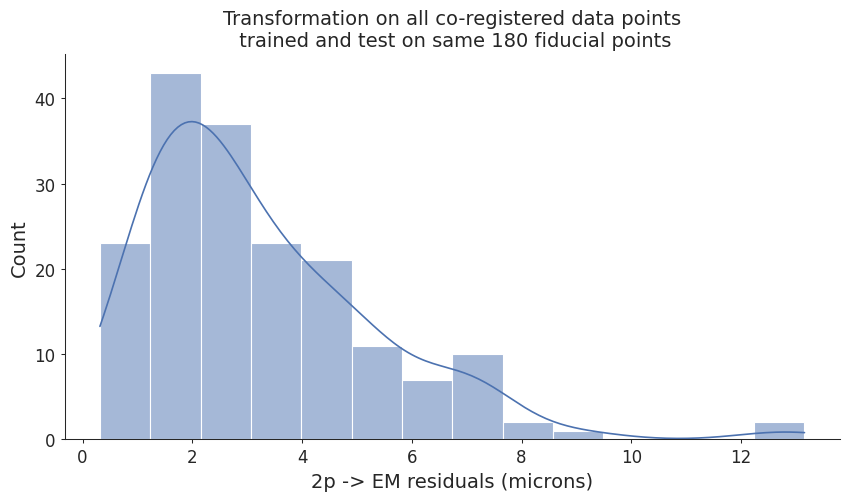

In [25]:
# estimate transformation
tform_allpts = coregister.transform.Transform(json=transform_obj)

tform_allpts.estimate(func_coreg_pts, em_coreg_pts)
fit_residuals = np.linalg.norm(tform_allpts.tform(func_coreg_pts)-em_coreg_pts, axis=1)

# tform_allpts.estimate(func_coreg_pts[ptset_mask], em_coreg_pts[ptset_mask])
# fit_residuals = np.linalg.norm(tform_allpts.tform(func_coreg_pts[ptset_mask])-em_coreg_pts[ptset_mask], axis=1)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Transformation on all co-registered data points\n trained and test on same {nPts} fiducial points')
sns.histplot(fit_residuals,ax=ax,kde=True)
ax.set_xlabel('2p -> EM residuals (microns)')

Text(0.5, 0, '2p -> EM residuals (microns)')

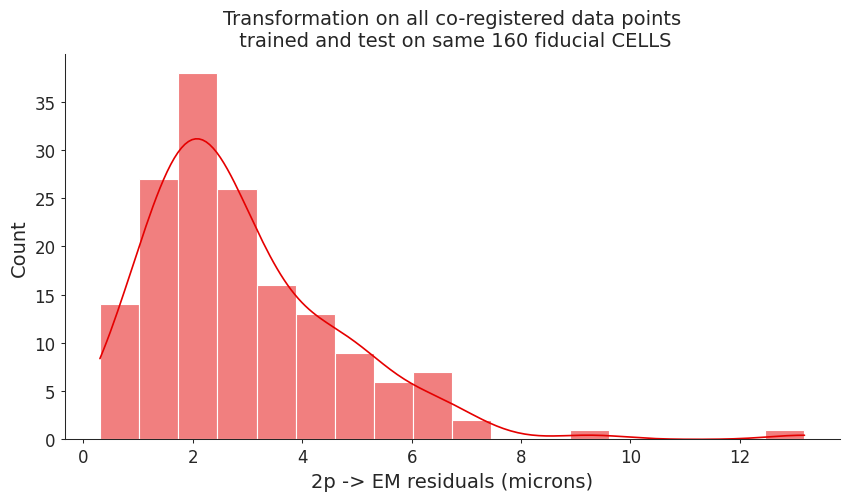

In [26]:

mask = np.array(coreg_df['type'].values == 'Cell',dtype=bool) 

# estimate transformation
tform_onlycells = coregister.transform.Transform(json=transform_obj)
tform_onlycells.estimate(func_coreg_pts[mask], em_coreg_pts[mask])

residuals_onlycells = np.linalg.norm(tform_onlycells.tform(func_coreg_pts[mask])-em_coreg_pts[mask], axis=1)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Transformation on all co-registered data points\n trained and test on same {np.sum(mask)} fiducial CELLS')
sns.histplot(residuals_onlycells,ax=ax,kde=True,color=cc[1])
ax.set_xlabel('2p -> EM residuals (microns)')

Text(0, 0.5, 'Residual (microns) using just cells')

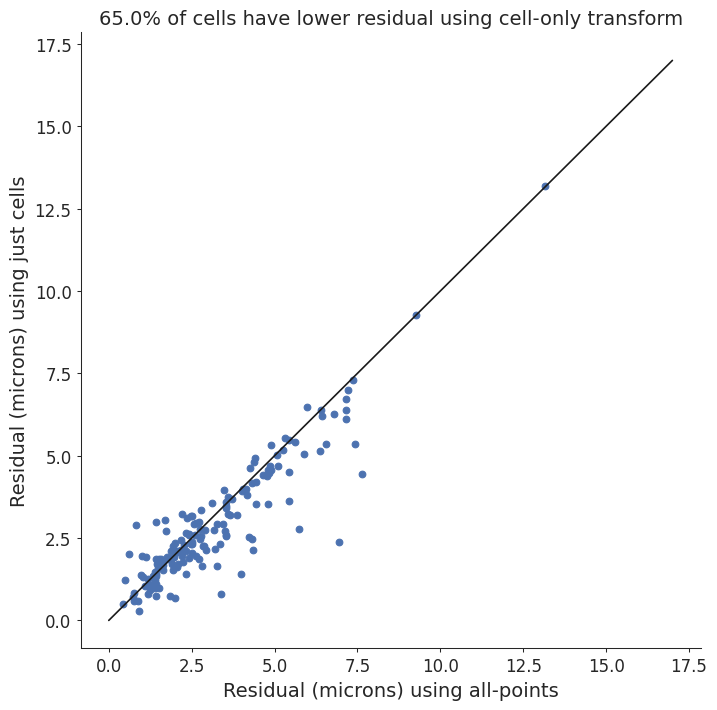

In [29]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(fit_residuals[mask],residuals_onlycells)
ax.plot([0,17],[0,17],'-k')

tmp =np.sum(residuals_onlycells < fit_residuals[mask]) /  len(residuals_onlycells)
ax.set_title(f'{tmp*100:.1f}% of cells have lower residual using cell-only transform')

ax.set_xlabel('Residual (microns) using all-points')
ax.set_ylabel('Residual (microns) using just cells')

## evaluate transformation

In [69]:
ptset_mask = []
for label in coreg_df['label'].values:
    if 'Pt' in label:
        ptset_mask.append(True)
    else:
        ptset_mask.append(False)
ptset_mask = np.array(ptset_mask)
cell_mask = np.array(coreg_df['type'].values == 'Cell')
mask = ptset_mask & cell_mask
np.sum(mask), np.sum(cell_mask)

(143, 161)

In [30]:
# evaluate l1out residual for all points
# TODO make helper method in coregister

# build leave-one-out dataset
@dataclasses.dataclass
class L1OutResult:
    src_pt : np.ndarray
    dst_pt : np.ndarray
    predicted_dst : np.ndarray
    pt_idx : str


l1out_transform_obj = {
        "name": "TransformList",
        "transforms": transform_list[:]
    }

src_vol_label = "opt"
dst_vol_label = "em"
l1out_src_pts = func_coreg_pts[:]
l1out_dst_pts = em_coreg_pts[:]

nPts = len(l1out_src_pts)


In [65]:
results = []
mean_residuals = []

#Loop over each cell and calculate tranform without it
for idx in range(l1out_src_pts.shape[0]):
    pts_mask = np.zeros(l1out_src_pts.shape[0], dtype=bool)
    pts_mask[idx] = True
    
    masked_src_pts = l1out_src_pts[~pts_mask]
    masked_dst_pts = l1out_dst_pts[~pts_mask]
    
    l1out_tform = coregister.transform.Transform(json=l1out_transform_obj)
    l1out_tform.estimate(masked_src_pts, masked_dst_pts)
    
    mean_residuals.append(np.linalg.norm(tform.tform(masked_src_pts) - masked_dst_pts, axis=1).mean())
    
    lno_src_pts = np.array([l1out_src_pts[idx]])
    lno_dst_pts = np.array([l1out_dst_pts[idx]])
    
    predicted_dsts = l1out_tform.tform(lno_src_pts)
    
    results.append(L1OutResult(
        src_pt=lno_src_pts[0], 
        dst_pt=lno_dst_pts[0],
        predicted_dst=predicted_dsts[0],
        pt_idx=idx
    ))



In [66]:
l1out_disps = np.array([r.dst_pt - r.predicted_dst for r in results])
l1out_residuals_allpts = np.linalg.norm(l1out_disps, axis=1)

In [67]:
len(l1out_residuals_allpts)

181

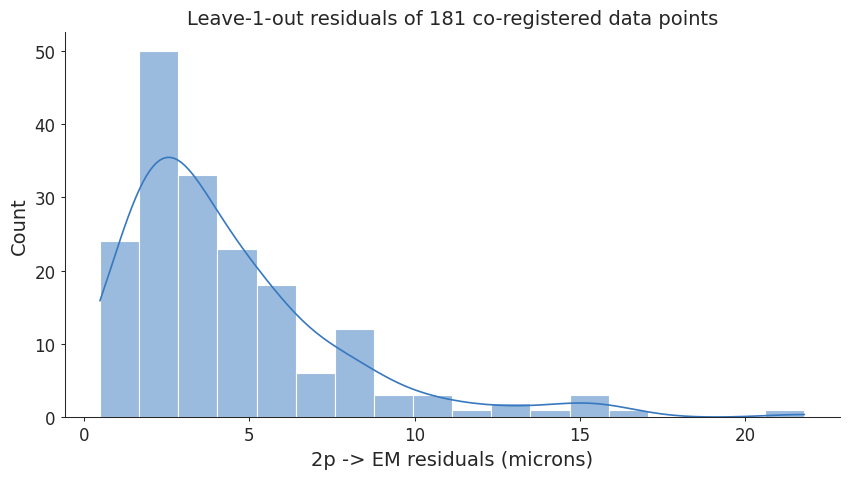

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Leave-1-out residuals of {nPts} co-registered data points')
sns.histplot(l1out_residuals_allpts,ax=ax,kde=True,color=cc[2])
ax.set_xlabel('2p -> EM residuals (microns)')
plt.savefig(os.path.join(PlotDir,'residuals_L1O_allpts.png'))


# fig, ax = plt.subplots(figsize=(10,5))
# ax.set_title('Residiual comparison')
# sns.histplot(fit_residuals,ax=ax,kde=True,color=cc[1],label='all')
# sns.histplot(l1out_residuals,ax=ax,kde=True,color=cc[2],label='L1O')
# ax.set_xlabel('2p -> EM residuals (microns)')
# ax.legend()
# plt.savefig(os.path.join(PlotDir,'residuals_compare.png'))


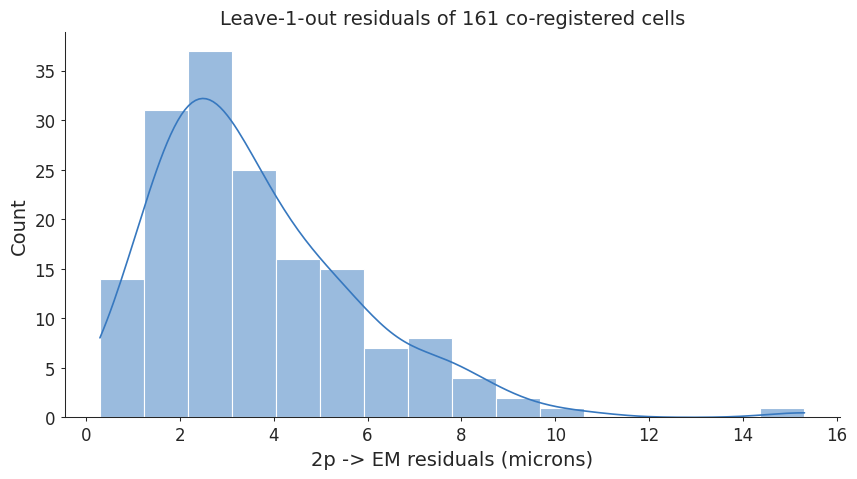

In [70]:
l1out_src_pts = func_coreg_pts[cell_mask]
l1out_dst_pts = em_coreg_pts[cell_mask]

nPts = len(l1out_src_pts)

results = []
mean_residuals = []

#Loop over each cell and calculate tranform without it
for idx in range(l1out_src_pts.shape[0]):
    pts_mask = np.zeros(l1out_src_pts.shape[0], dtype=bool)
    pts_mask[idx] = True
    
    masked_src_pts = l1out_src_pts[~pts_mask]
    masked_dst_pts = l1out_dst_pts[~pts_mask]
    
    l1out_tform = coregister.transform.Transform(json=l1out_transform_obj)
    l1out_tform.estimate(masked_src_pts, masked_dst_pts)
    
    mean_residuals.append(np.linalg.norm(tform.tform(masked_src_pts) - masked_dst_pts, axis=1).mean())
    
    lno_src_pts = np.array([l1out_src_pts[idx]])
    lno_dst_pts = np.array([l1out_dst_pts[idx]])
    
    predicted_dsts = l1out_tform.tform(lno_src_pts)
    
    results.append(L1OutResult(
        src_pt=lno_src_pts[0], 
        dst_pt=lno_dst_pts[0],
        predicted_dst=predicted_dsts[0],
        pt_idx=idx
    ))

l1out_disps = np.array([r.dst_pt - r.predicted_dst for r in results])
l1out_residuals_onlycells = np.linalg.norm(l1out_disps, axis=1)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'Leave-1-out residuals of {nPts} co-registered cells')
sns.histplot(l1out_residuals_onlycells,ax=ax,kde=True,color=cc[2])
ax.set_xlabel('2p -> EM residuals (microns)')
plt.savefig(os.path.join(PlotDir,'residuals_L1O_onlycells.png'))


# fig, ax = plt.subplots(figsize=(10,5))
# ax.set_title('Residiual comparison')
# sns.histplot(fit_residuals,ax=ax,kde=True,color=cc[1],label='all')
# sns.histplot(l1out_residuals,ax=ax,kde=True,color=cc[2],label='L1O')
# ax.set_xlabel('2p -> EM residuals (microns)')
# ax.legend()
# plt.savefig(os.path.join(PlotDir,'residuals_compare.png'))


(0.0, 16.0)

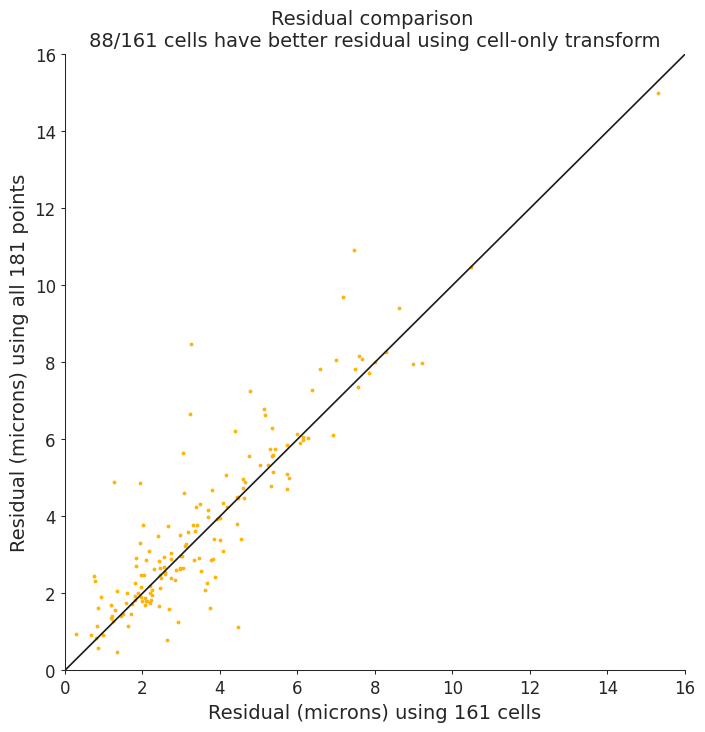

In [75]:
fig, ax = plt.subplots(figsize=(8,8))

ax.plot([0,25],[0,25],'-k')
ax.scatter(l1out_residuals_onlycells,l1out_residuals_allpts[cell_mask],color=cc[0],marker='.',s=15)
ax.set_xlabel(f'Residual (microns) using {np.sum(cell_mask)} cells')
ax.set_ylabel(f'Residual (microns) using all {len(l1out_residuals_allpts)} points')
nBetter = np.sum(l1out_residuals_onlycells < l1out_residuals_allpts[cell_mask])
ax.set_title(f'Residual comparison \n{nBetter}/{np.sum(cell_mask)} cells have better residual using cell-only transform')
ax.set_xlim([0,16]);ax.set_ylim([0,16])

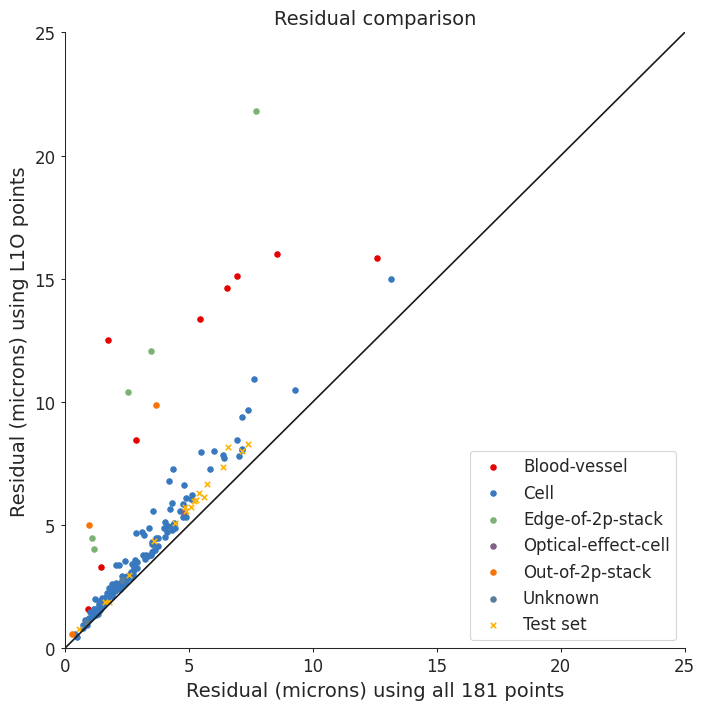

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Residual comparison')

ax.plot([0,25],[0,25],'-k')

for ii, type in enumerate(np.unique(coreg_df['type'])):
    mask = (coreg_df['type'].values == type) & ptset_mask
    ax.scatter(fit_residuals[mask],l1out_residuals[mask],color=cc[ii+1],s=15,label=type)

ax.scatter(fit_residuals[~ptset_mask],l1out_residuals[~ptset_mask],color=cc[0],marker='x',s=15,label='Test set')
ax.set_xlabel(f'Residual (microns) using all {nPts} points')
ax.set_ylabel('Residual (microns) using L1O points')
ax.legend()
ax.set_xlim([0,25]);ax.set_ylim([0,25])
plt.savefig(os.path.join(PlotDir,'residuals_compare.png'))

Text(0, 0.5, 'Delta-residual (microns): L1O - all')

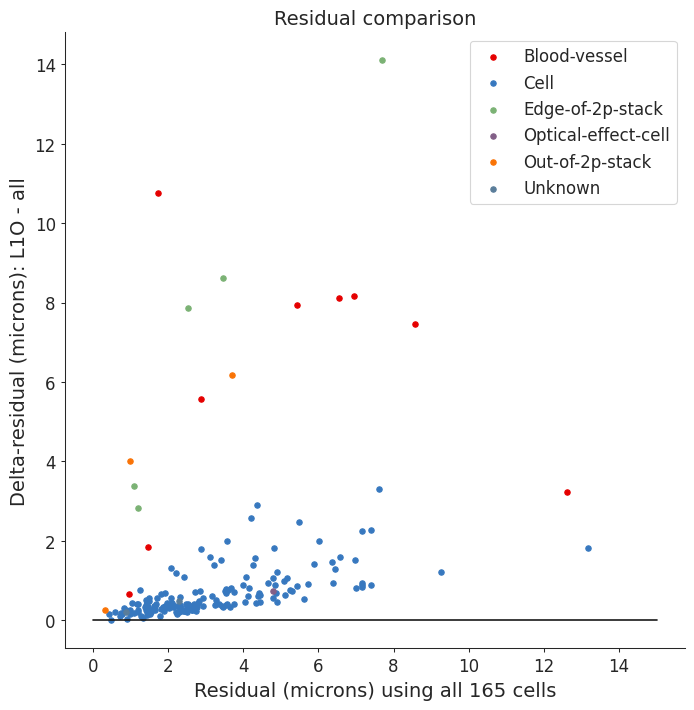

In [39]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Residual comparison')


for ii, type in enumerate(np.unique(coreg_df['type'])):
    mask = coreg_df['type'].values == type
    ax.scatter(fit_residuals[mask],l1out_residuals[mask]-fit_residuals[mask],color=cc[ii+1],s=15,label=type)
    
ax.legend()
ax.plot([0,15],[0,0],'-k')
ax.set_xlabel('Residual (microns) using all 165 cells')
ax.set_ylabel('Delta-residual (microns): L1O - all')

# ax.set_xlim([0,25]);ax.set_ylim([0,25])
# plt.savefig(os.path.join(PlotDir,'residuals_compare.png'))

In [133]:
## What about comparing (L1O) residual for cells using only-cell transform vs all point transform

# evaluate l1out residual for all points
# TODO make helper method in coregister
results_allpts = []
mean_residuals_allpts = []

results_onlycell = []
mean_residuals_onlycell = []

point_types = coreg_df['type'].values
cell_mask = point_types == 'Cell'

#Loop over each cell and calculate tranform without it
for idx in range(func_coreg_pts.shape[0]):
    
    if point_types[idx] != 'Cell':
        continue

    #First calculate transform with all points but L1O cell
    pts_mask = np.zeros(func_coreg_pts.shape[0], dtype=bool); pts_mask[idx] = True
    src = func_coreg_pts[~pts_mask]; dst = em_coreg_pts[~pts_mask]
    l1out_tform_allpts = coregister.transform.Transform(json=l1out_transform_obj)
    l1out_tform_allpts.estimate(src, dst)
    
    #Get overall residual from fit
    mean_residuals_allpts.append(np.linalg.norm(l1out_tform_allpts.tform(src) - dst, axis=1).mean())

    #Get predicted position of L1O cell    
    predicted_dsts = l1out_tform_allpts.tform(func_coreg_pts[idx].reshape(1,-1))
    
    results_allpts.append(L1OutResult(
        src_pt=func_coreg_pts[idx], 
        dst_pt=em_coreg_pts[idx],
        predicted_dst=predicted_dsts[0],
        pt_idx=idx
    ))

    ## Second, calculate transform with only cells but L1O cell
    pts_mask = np.zeros(func_coreg_pts.shape[0], dtype=bool); pts_mask[idx] = True
    mask = ~pts_mask & cell_mask

    src = func_coreg_pts[mask]; dst = em_coreg_pts[mask]
    l1out_tform_onlycells = coregister.transform.Transform(json=l1out_transform_obj)
    l1out_tform_onlycells.estimate(src, dst)
    
    #Get overall residual from fit
    mean_residuals_onlycell.append(np.linalg.norm(l1out_tform_onlycells.tform(src) - dst, axis=1).mean())

    #Get predicted position of L1O cell    
    predicted_dsts = l1out_tform_onlycells.tform(func_coreg_pts[idx].reshape(1,-1))
    
    results_onlycell.append(L1OutResult(
        src_pt=func_coreg_pts[idx], 
        dst_pt=em_coreg_pts[idx],
        predicted_dst=predicted_dsts[0],
        pt_idx=idx
    ))




In [134]:
l1out_disps = np.array([r.dst_pt - r.predicted_dst for r in results_allpts])
l1out_allpts_residuals = np.linalg.norm(l1out_disps, axis=1)

l1out_disps = np.array([r.dst_pt - r.predicted_dst for r in results_onlycell])
l1out_onlycells_residuals = np.linalg.norm(l1out_disps, axis=1)

Text(0, 0.5, 'L1O residual (microns) using just cells')

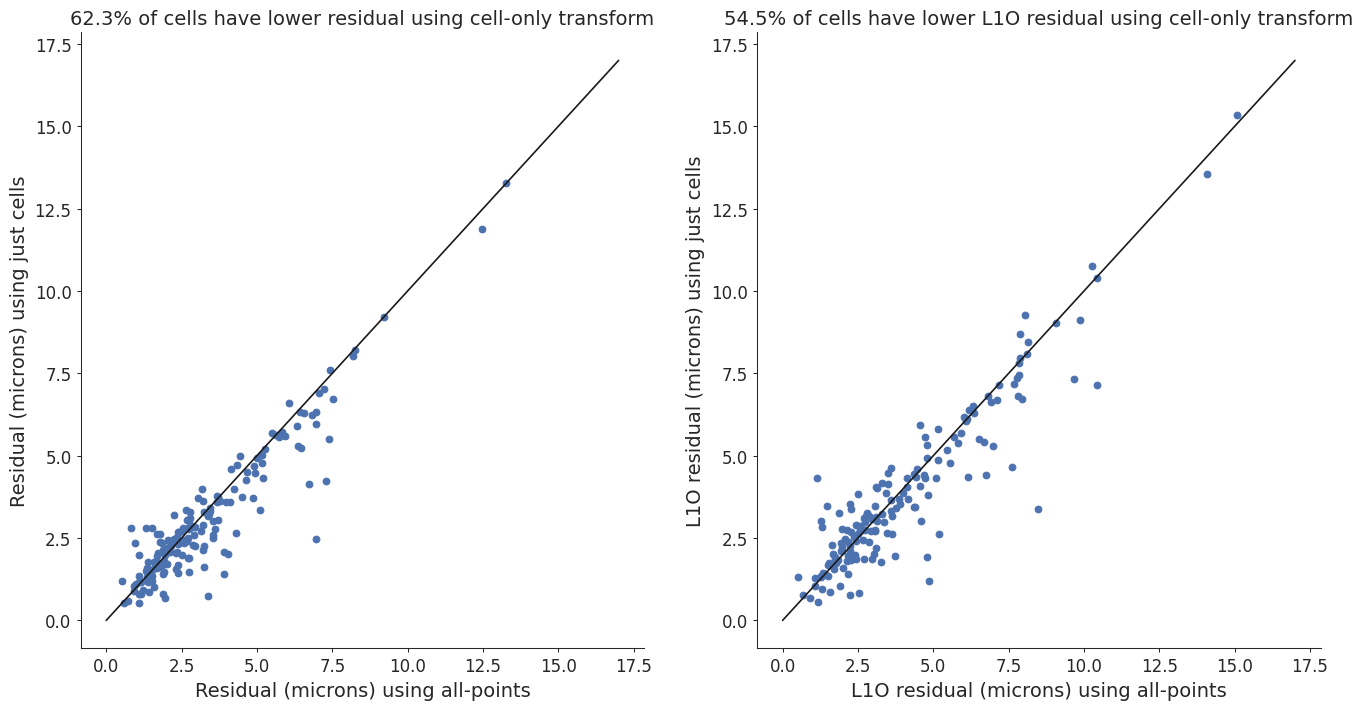

In [149]:
mask = coreg_df['type'].values == 'Cell'

fig, axes = plt.subplots(1,2,figsize=(16,8))
ax = axes[0]
ax.scatter(residuals_allpts[mask],residuals_onlycells)
ax.plot([0,17],[0,17],'-k')

tmp =np.sum(residuals_onlycells < residuals_allpts[mask]) /  len(residuals_onlycells)
ax.set_title(f'{tmp*100:.1f}% of cells have lower residual using cell-only transform')

ax.set_xlabel('Residual (microns) using all-points')
ax.set_ylabel('Residual (microns) using just cells')

# fig, ax = plt.subplots(figsize=(8,8))
ax = axes[1]
ax.scatter(l1out_allpts_residuals,l1out_onlycells_residuals)
ax.plot([0,17],[0,17],'-k')

tmp =np.sum(l1out_onlycells_residuals < l1out_allpts_residuals) /  len(l1out_onlycells_residuals)
ax.set_title(f'{tmp*100:.1f}% of cells have lower L1O residual using cell-only transform')
ax.set_xlabel('L1O residual (microns) using all-points')
ax.set_ylabel('L1O residual (microns) using just cells')

Text(0, 0.5, 'Delta-residual (microns): L1O residual using "all-pts" - "only-cells"')

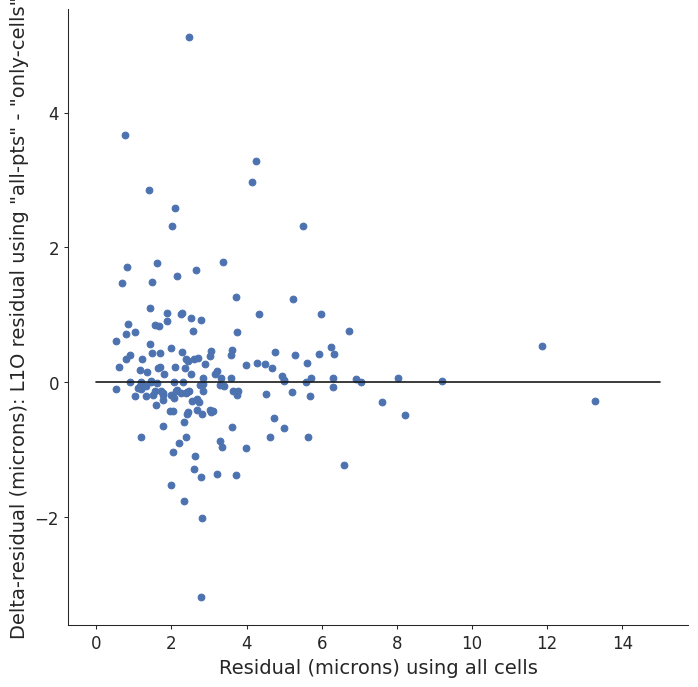

In [148]:
fig, ax = plt.subplots(figsize=(8,8))
# ax = axes[1]

ax.scatter(residuals_onlycells, l1out_allpts_residuals - l1out_onlycells_residuals)

ax.plot([0,15],[0,0],'-k')
ax.set_xlabel('Residual (microns) using all cells')
ax.set_ylabel('Delta-residual (microns): L1O residual using "all-pts" - "only-cells"')

# ax.set_xlabel('L1O residual (microns) using all-points')
# ax.set_ylabel('L1O residual (microns) using just cells')

## Calculating metric by L1O transformation

In [31]:
ptset_mask = []
for label in coreg_df['label'].values:
    if 'Pt' in label:
        ptset_mask.append(True)
    else:
        ptset_mask.append(False)
ptset_mask = np.array(ptset_mask)
cell_mask = np.array(coreg_df['type'].values == 'Cell')
mask = ptset_mask & cell_mask
np.sum(mask)

142

In [32]:
## Q: Are all of these transformations being fit and applied successively? I think so
transform_list = [
    {
        "name": "PolynomialModel",
        "order": 1,
        "regularization": [0, 0, 0, 0]
    },
    {
        "name": "ChunkedModel",
        "order": 1,
        "nchunks": 3,
        "axis": 0
    },
    {
        "name": "SplineModel",
        "ncntrl": [3, 3, 3],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [5, 5, 5],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e8]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6] # originally last was 1e8
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e9]
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]  # originally last was 1e9
    },
    {
        "name": "SplineModel",
        "voronoi_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 5e4]
    },
        
]

transform_obj = {
        "name": "TransformList",
        "transforms": transform_list
    }

func_coreg_pts = np.array(coreg_df[["optx", "opty", "optz"]],dtype=float)
em_coreg_pts = np.array(coreg_df[["emx", "emy", "emz"]],dtype=float)
point_types = list(coreg_df['type'].values)
nPts = len(func_coreg_pts)
cell_indices = np.where(np.array(point_types) == 'Cell')[0]
nCells = len(cell_indices)

func_coreg_cells = func_coreg_pts[cell_indices]
em_coreg_cells = em_coreg_pts[cell_indices]

# # estimate transformation
# tform = coregister.transform.Transform(json=transform_obj)
# tform.estimate(func_coreg_pts[mask], em_coreg_pts[mask])
func_coreg_cells.shape


(160, 3)

In [33]:
#Get 2p functional data for column 1 volumn 3
nwb_file = '/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data/nwbs/processed/M409828_13_20181213.nwb'
with ROI_mask_nwb(nwb_file, vol=3, mode="r") as rmn:
    # import pdb; pdb.set_trace()
    all_roi_info = [*rmn.yield_roi_info()] 

In [34]:
# Get 2p ROI center of mass 
all_roi_raw_center_pts = np.array([center_from_pix_mask(roi.pix_mask).tolist() + [roi.plane_z] for roi in all_roi_info])
pika_scores = np.array([roi.pika_score for roi in all_roi_info])
valid_cells = pika_scores > 0.5

# Get names
all_roi_names = np.array([roi.name for roi in all_roi_info])
all_roi_chasenames = np.array([roi.chase_ROI for roi in all_roi_info])
indy = np.where([name in add_these_invalid_cells for name in all_roi_chasenames])[0]
valid_cells[indy] = True

#Get pixel areas
all_roi_areas = np.array([len(roi.pix_mask[0]) for roi in all_roi_info])

# #Select only valid and non-duplicate cells
# indices = get_array_subset_indices(all_roi_chasenames, valid_roi_ids)

# Transform raw 2p coordinates into co-registration space (micron space)
all_roi_func_coreg_pts = transform_pts(func_raw2coreg_tform, all_roi_raw_center_pts)

# #Subselect
all_roi_raw_center_pts = all_roi_raw_center_pts[valid_cells]
all_roi_func_coreg_pts = all_roi_func_coreg_pts[valid_cells]
all_roi_names = all_roi_names[valid_cells]
all_roi_chasenames = all_roi_chasenames[valid_cells]
# all_roi_em_final_pts_nms = all_roi_em_final_pts_nms[valid_cells]

def apply_tform_all_rois(tform):

    #Transform 2p functional locations to EM using transform created using all co-registered cells
    all_roi_em_coreg_pts = tform.tform(all_roi_func_coreg_pts)

    # Transform coregistered points back into EM space 
    all_roi_em_final_pts_voxels = transform_pts(em_coreg2final_tform, all_roi_em_coreg_pts)
    all_roi_em_final_pts_nms = all_roi_em_final_pts_voxels * em_final_voxel_size

    return all_roi_em_final_pts_nms


In [35]:
# em_pts = np.array(coreg_cells_df[["pt_position_x", "pt_position_y", "pt_position_z"]])
# func_pts = np.array(coreg_cells_df[["ophys_x", "ophys_y", "ophys_z"]])
# coreg_onlycells_df
coreg_em_nucleus_pts_nm = np.array(coreg_cells_df[["pt_position_x", "pt_position_y", "pt_position_z"]])
coreg_em_nucleus_pts_nm.shape

(160, 3)

In [36]:

# define bounding box for table query
min_nm = coreg_em_nucleus_pts_nm.min(axis=0)
max_nm = coreg_em_nucleus_pts_nm.max(axis=0)

# 50 um buffer around area
buffer_um = 50
buffer_nm = buffer_um * 1000
buffer = np.array((buffer_nm, buffer_nm, buffer_nm))

query_bbox = np.array([
    min_nm - buffer,
    max_nm + buffer
])

#Get all cells in EM volume within bounding region
res = em_client.materialize.query_table(
    "nucleus_detection_v0",filter_spatial_dict={"pt_position": query_bbox})

#Extract point position 
nucleus_pts = np.array([i for i in res.pt_position])
nucleus_ids = np.array([i for i in res.id])
print(nucleus_pts.shape)
# Create KD-tree of neucleus pts which we will use to match test set 
kdt = scipy.spatial.KDTree(nucleus_pts)


(17974, 3)


In [37]:
dist_list = []
indy_list = []

results = []

iCell = 0
#Loop over each cell and calculate transform without it
for idx, row in tqdm(coreg_df.iterrows()):
    
    if (row.flag == False) | (row.type != 'Cell'): # | ('Test' in row.label):
        continue

    #First calculate transform with all points but L1O cell
    pts_mask = np.zeros(func_coreg_pts.shape[0], dtype=bool); pts_mask[idx] = True
    mask = ~pts_mask# & cell_mask
    src = func_coreg_pts[mask]; dst = em_coreg_pts[mask]

    l1out_tform = coregister.transform.Transform(json=l1out_transform_obj)
    l1out_tform.estimate(src, dst)
    
    #Get predicted position of L1O cell    
    predicted_em_coreg = l1out_tform.tform(func_coreg_pts[idx].reshape(1,-1))

    #Transform coregistered points back into EM space 
    l1out_roi_em_final_pts_voxels = transform_pts(em_coreg2final_tform, predicted_em_coreg)
    l1out_roi_em_final_pts_nms = l1out_roi_em_final_pts_voxels * em_final_voxel_size

    #Get true em location
    true_em_nm = coreg_df.at[idx,'pt_position'] #em_final_em_nm,pt_position

    #Apply transform to all 2p-rois
    all_roi_em_final_pts_nms = apply_tform_all_rois(l1out_tform)

    # print(all_roi_em_final_pts_nms.shape)
    # pdb.set_trace()
    # results_allpts.append(L1OutResult(
    #     src_pt=func_coreg_pts[idx], 
    #     dst_pt=em_coreg_pts[idx],
    #     predicted_dst=predicted_dsts[0],
    #     pt_idx=idx
    # ))

    #Get L1O test set index
    l1out_roi_name = coreg_df.at[idx,'russel_key']
    test_set_idxs = get_array_subset_indices(all_roi_names, l1out_roi_name)

    #Get transformed 2p-EM location of L1O cell
    test_centers_em_nm = all_roi_em_final_pts_nms[test_set_idxs]

    #Get residuals on L1O cell
    disps = test_centers_em_nm - true_em_nm
    L1O_true_v_transformed_residuals = np.linalg.norm(disps)

    #Calculate residuals of corresponded point, which is not necessarily the same as the 2p-em transformed one 
    disps = l1out_roi_em_final_pts_nms - true_em_nm
    L1O_true_v_corresponded_residuals = np.linalg.norm(disps)
    
    #Now let's see if this would "snap" to the correct nucleus ID
    distances, indices = kdt.query(test_centers_em_nm, k=10)
    potential_nucleus_ids = nucleus_ids[indices]
    selected_nucleus_id = nucleus_ids[indices[0]]

    #Take closest "not-selected" cell, which is probably 2nd closest cell, but not necessarily
    indy = np.where(potential_nucleus_ids != coreg_df.at[idx,'em_id'])[0][0] 
    metric = distances[indy] - L1O_true_v_transformed_residuals
    # metric = distances[indy] - distances[0]
    # pdb.set_trace()
    #Do the same for the corresponded point that was transformed as well
    distances2, indices2 = kdt.query(np.squeeze(l1out_roi_em_final_pts_nms), k=10)
    potential_nucleus_ids = nucleus_ids[indices2]
    selected_nucleus_id2= nucleus_ids[indices2[0]]
    
    indy = np.where(potential_nucleus_ids != coreg_df.at[idx,'em_id'])[0][0] 
    metric2 = distances2[indy] - L1O_true_v_corresponded_residuals

    results.append((idx, row.chase_key, row.em_id, row.em_final_em_nm, test_centers_em_nm, nucleus_ids[indices[0]], metric, l1out_roi_em_final_pts_nms, nucleus_ids[indices2[0]],metric2))
    dist_list.append((distances,distances2))
    indy_list.append((indices,indices2))
    iCell += 1
    

180it [03:48,  1.27s/it]


In [38]:
metrics_df = pd.DataFrame(np.stack(results),columns=['idx','chase_key','em_id','em_final_em_nm','test_centers_em_nm','predicted_nucleus_id','metric','l1out_roi_em_final_pts_nms','predicted_nucleus_id2','metric2'])
np.sum(metrics_df['em_id'].values == metrics_df['predicted_nucleus_id'].values)

/home/david.wyrick/anaconda3/envs/v1dd/lib/python3.10/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


137

In [39]:
true_em_nm = np.stack(metrics_df['em_final_em_nm'])
# true_em_nm = np.stack(coreg_onlycells_df['pt_position'])
predicted_em_nm = np.stack(metrics_df['test_centers_em_nm'])

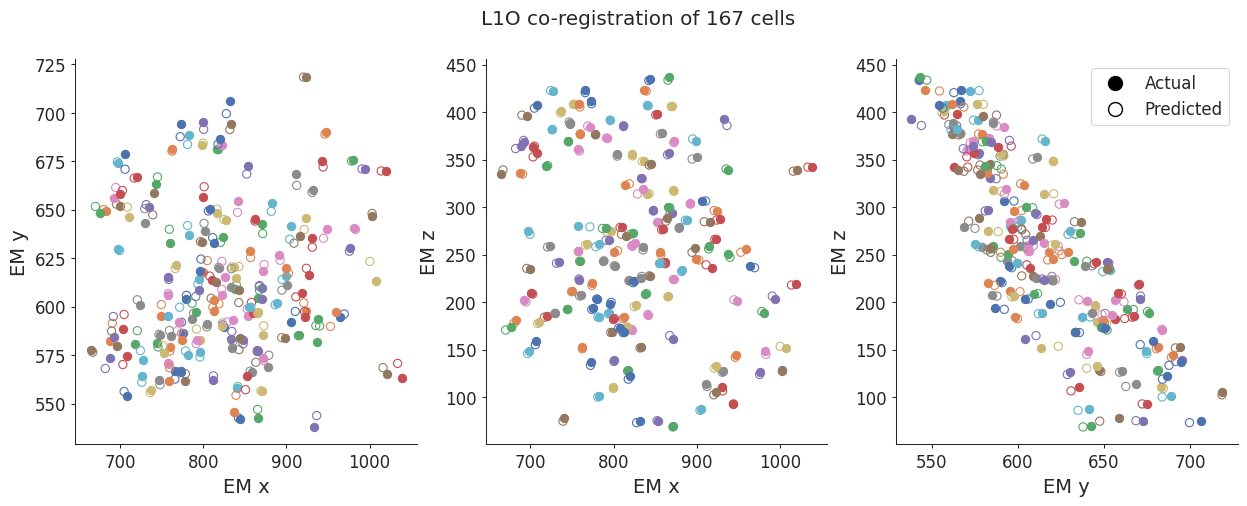

In [40]:
import matplotlib as mpl
scalar = 1000
ax_sizes = (512, 512, 6)

fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('L1O co-registration of 167 cells')
axes_labels = ['x','y','z']; lims = [[750,925],[560,660],[150,350]]
for ii, xy in enumerate(itertools.combinations(np.arange(3),2)):
    _xaxis, _yaxis = xy
    ax = axes[ii]
    # ax.scatter(corr_pts_em_nm[:, _xaxis]/scalar, corr_pts_em_nm[:, _yaxis]/scalar, marker='.',color='k',s=40, label='Co-registered cells used for creating transform')
    for jj in range(predicted_em_nm.shape[0]):
        color = ax.scatter(true_em_nm[jj, _xaxis]/scalar, true_em_nm[jj, _yaxis]/scalar,marker= 'o', s=35).get_facecolors()[0]
        ax.scatter(predicted_em_nm[jj, _xaxis]/scalar, predicted_em_nm[jj, _yaxis]/scalar,facecolors="none", edgecolors=color, marker='o',s=35)

    # sns.scatterplot(coreg_table_centers_em_nm[indy2, _xaxis]/scalar, coreg_table_centers_em_nm[indy2, _yaxis]/scalar,marker= '*', s=70, label='Co-registered table')
    if ii == 2:
        ax.legend(handles=[
            mpl.lines.Line2D([0], [0],lw=0, label="Actual", marker="o", color="none", markerfacecolor="black", markersize=10),
            mpl.lines.Line2D([0], [0],lw=0, label="Predicted", marker="o", color="none", markeredgecolor="black", markersize=10)
        ],  bbox_transform=ax.transAxes)
    # ax.set_xlim(lims[_xaxis])
    # ax.set_ylim(lims[_yaxis])
    ax.set_xlabel(f'EM {axes_labels[_xaxis]}')
    ax.set_ylabel(f'EM {axes_labels[_yaxis]}')
plt.savefig(os.path.join(PlotDir,'EM_location_predvtrue_usingallpts.pdf'))

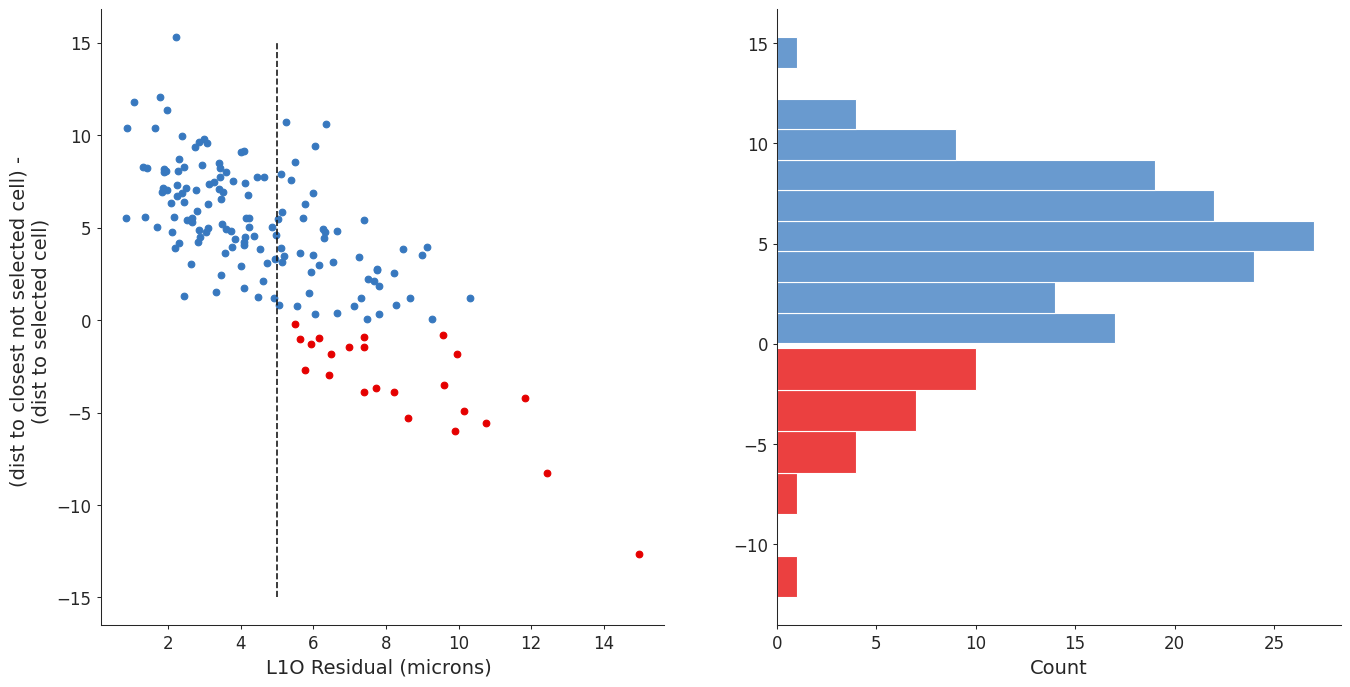

In [41]:
residuals = np.linalg.norm(np.stack(metrics_df['em_final_em_nm'] - metrics_df['test_centers_em_nm']),axis=1)
residual_cutoff = 5
mask = metrics_df['em_id'].values != metrics_df['predicted_nucleus_id'].values


fig, axes = plt.subplots(1,2,figsize=(16,8))

ax = axes[0]
ax.scatter(residuals[~mask]/1000,metrics_df['metric'].values[~mask]/1000,color=cc[2])
ax.scatter(residuals[mask]/1000,metrics_df['metric'].values[mask]/1000,color=cc[1])
ax.set_xlabel('L1O Residual (microns) ')
ax.set_ylabel('(dist to closest not selected cell) - \n(dist to selected cell) ')
ax.vlines(residual_cutoff,-15,15,ls='--',color='k')
ax = axes[1]
sns.histplot(y=metrics_df['metric'].values[~mask]/1000,color=cc[2],ax=ax)
sns.histplot(y=metrics_df['metric'].values[mask]/1000,color=cc[1],ax=ax)
plt.savefig(os.path.join(PlotDir,'correspondence_metric_usingallpts.pdf'))

In [42]:
dist_list = []
indy_list = []

results = []

iCell = 0
#Loop over each cell and calculate transform without it
for idx, row in tqdm(coreg_df.iterrows()):
    
    if (row.flag == False) | (row.type != 'Cell'): # | ('Test' in row.label):
        continue

    #First calculate transform with all points but L1O cell
    pts_mask = np.zeros(func_coreg_pts.shape[0], dtype=bool); pts_mask[idx] = True
    mask = ~pts_mask & cell_mask
    src = func_coreg_pts[mask]; dst = em_coreg_pts[mask]

    l1out_tform = coregister.transform.Transform(json=l1out_transform_obj)
    l1out_tform.estimate(src, dst)
    
    #Get predicted position of L1O cell    
    predicted_em_coreg = l1out_tform.tform(func_coreg_pts[idx].reshape(1,-1))

    #Transform coregistered points back into EM space 
    l1out_roi_em_final_pts_voxels = transform_pts(em_coreg2final_tform, predicted_em_coreg)
    l1out_roi_em_final_pts_nms = l1out_roi_em_final_pts_voxels * em_final_voxel_size

    #Get true em location
    true_em_nm = coreg_df.at[idx,'pt_position'] #em_final_em_nm,pt_position

    #Apply transform to all 2p-rois
    all_roi_em_final_pts_nms = apply_tform_all_rois(l1out_tform)

    # print(all_roi_em_final_pts_nms.shape)
    # pdb.set_trace()
    # results_allpts.append(L1OutResult(
    #     src_pt=func_coreg_pts[idx], 
    #     dst_pt=em_coreg_pts[idx],
    #     predicted_dst=predicted_dsts[0],
    #     pt_idx=idx
    # ))

    #Get L1O test set index
    l1out_roi_name = coreg_df.at[idx,'russel_key']
    test_set_idxs = get_array_subset_indices(all_roi_names, l1out_roi_name)

    #Get transformed 2p-EM location of L1O cell
    test_centers_em_nm = all_roi_em_final_pts_nms[test_set_idxs]

    #Get residuals on L1O cell
    disps = test_centers_em_nm - true_em_nm
    L1O_true_v_transformed_residuals = np.linalg.norm(disps)

    #Calculate residuals of corresponded point, which is not necessarily the same as the 2p-em transformed one 
    disps = l1out_roi_em_final_pts_nms - true_em_nm
    L1O_true_v_corresponded_residuals = np.linalg.norm(disps)
    
    #Now let's see if this would "snap" to the correct nucleus ID
    distances, indices = kdt.query(test_centers_em_nm, k=10)
    potential_nucleus_ids = nucleus_ids[indices]
    selected_nucleus_id = nucleus_ids[indices[0]]

    #Take closest "not-selected" cell, which is probably 2nd closest cell, but not necessarily
    indy = np.where(potential_nucleus_ids != coreg_df.at[idx,'em_id'])[0][0] 
    metric = distances[indy] - L1O_true_v_transformed_residuals
    # metric = distances[indy] - distances[0]
    # pdb.set_trace()
    #Do the same for the corresponded point that was transformed as well
    distances2, indices2 = kdt.query(np.squeeze(l1out_roi_em_final_pts_nms), k=10)
    potential_nucleus_ids = nucleus_ids[indices2]
    selected_nucleus_id2= nucleus_ids[indices2[0]]
    
    indy = np.where(potential_nucleus_ids != coreg_df.at[idx,'em_id'])[0][0] 
    metric2 = distances2[indy] - L1O_true_v_corresponded_residuals

    results.append((idx, row.chase_key, row.em_id, row.em_final_em_nm, test_centers_em_nm, nucleus_ids[indices[0]], metric, l1out_roi_em_final_pts_nms, nucleus_ids[indices2[0]],metric2))
    dist_list.append((distances,distances2))
    indy_list.append((indices,indices2))
    iCell += 1
    

180it [03:21,  1.12s/it]


In [43]:
metrics_df2 = pd.DataFrame(np.stack(results),columns=['idx','chase_key','em_id','em_final_em_nm','test_centers_em_nm','predicted_nucleus_id','metric','l1out_roi_em_final_pts_nms','predicted_nucleus_id2','metric2'])
np.sum(metrics_df2['em_id'].values == metrics_df2['predicted_nucleus_id'].values)

/home/david.wyrick/anaconda3/envs/v1dd/lib/python3.10/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


134

Text(0, 0.5, '(dist to closest not selected cell) - \n(dist to selected cell) ')

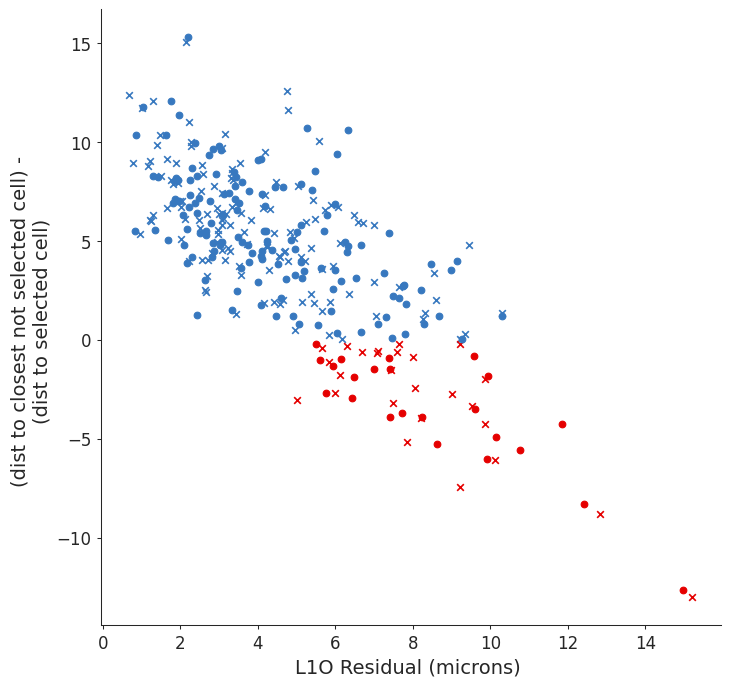

In [44]:
residuals2 = np.linalg.norm(np.stack(metrics_df2['em_final_em_nm'] - metrics_df2['test_centers_em_nm']),axis=1)
mask2 = metrics_df2['em_id'].values != metrics_df2['predicted_nucleus_id'].values

residuals = np.linalg.norm(np.stack(metrics_df['em_final_em_nm'] - metrics_df['test_centers_em_nm']),axis=1)
mask = metrics_df['em_id'].values != metrics_df['predicted_nucleus_id'].values

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(residuals2[~mask2]/1000,metrics_df2['metric'].values[~mask2]/1000,color=cc[2],marker='x')
ax.scatter(residuals2[mask2]/1000,metrics_df2['metric'].values[mask2]/1000,color=cc[1],marker='x')

ax.scatter(residuals[~mask]/1000,metrics_df['metric'].values[~mask]/1000,color=cc[2])
ax.scatter(residuals[mask]/1000,metrics_df['metric'].values[mask]/1000,color=cc[1])
ax.set_xlabel('L1O Residual (microns) ')
ax.set_ylabel('(dist to closest not selected cell) - \n(dist to selected cell) ')

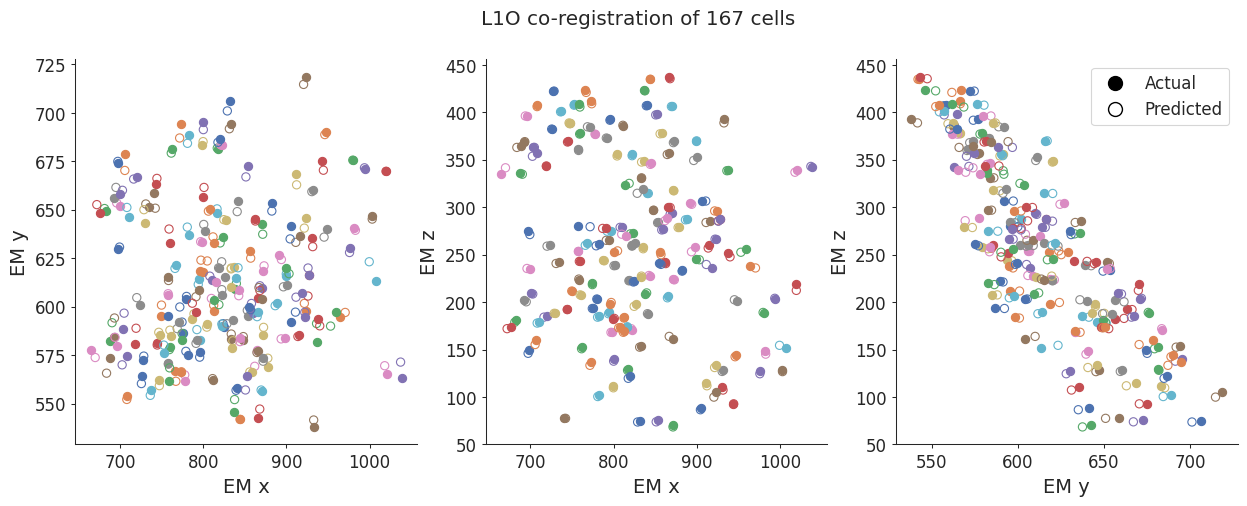

In [60]:
true_em_nm = np.stack(metrics_df2['em_final_em_nm'])
# true_em_nm = np.stack(coreg_onlycells_df['pt_position'])
predicted_em_nm = np.stack(metrics_df2['test_centers_em_nm'])

import matplotlib as mpl
scalar = 1000
ax_sizes = (512, 512, 6)

fig, axes = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('L1O co-registration of 167 cells')
axes_labels = ['x','y','z']; lims = [[750,925],[560,660],[150,350]]
for ii, xy in enumerate(itertools.combinations(np.arange(3),2)):
    _xaxis, _yaxis = xy
    ax = axes[ii]
    # ax.scatter(corr_pts_em_nm[:, _xaxis]/scalar, corr_pts_em_nm[:, _yaxis]/scalar, marker='.',color='k',s=40, label='Co-registered cells used for creating transform')
    for jj in range(predicted_em_nm.shape[0]):
        color = ax.scatter(true_em_nm[jj, _xaxis]/scalar, true_em_nm[jj, _yaxis]/scalar,marker= 'o', s=35).get_facecolors()[0]
        ax.scatter(predicted_em_nm[jj, _xaxis]/scalar, predicted_em_nm[jj, _yaxis]/scalar,facecolors="none", edgecolors=color, marker='o',s=35)

    # sns.scatterplot(coreg_table_centers_em_nm[indy2, _xaxis]/scalar, coreg_table_centers_em_nm[indy2, _yaxis]/scalar,marker= '*', s=70, label='Co-registered table')
    if ii == 2:
        ax.legend(handles=[
            mpl.lines.Line2D([0], [0],lw=0, label="Actual", marker="o", color="none", markerfacecolor="black", markersize=10),
            mpl.lines.Line2D([0], [0],lw=0, label="Predicted", marker="o", color="none", markeredgecolor="black", markersize=10)
        ],  bbox_transform=ax.transAxes)
    # ax.set_xlim(lims[_xaxis])
    # ax.set_ylim(lims[_yaxis])
    ax.set_xlabel(f'EM {axes_labels[_xaxis]}')
    ax.set_ylabel(f'EM {axes_labels[_yaxis]}')
plt.savefig(os.path.join(PlotDir,'EM_location_predvtrue_usingjustcells.pdf'))

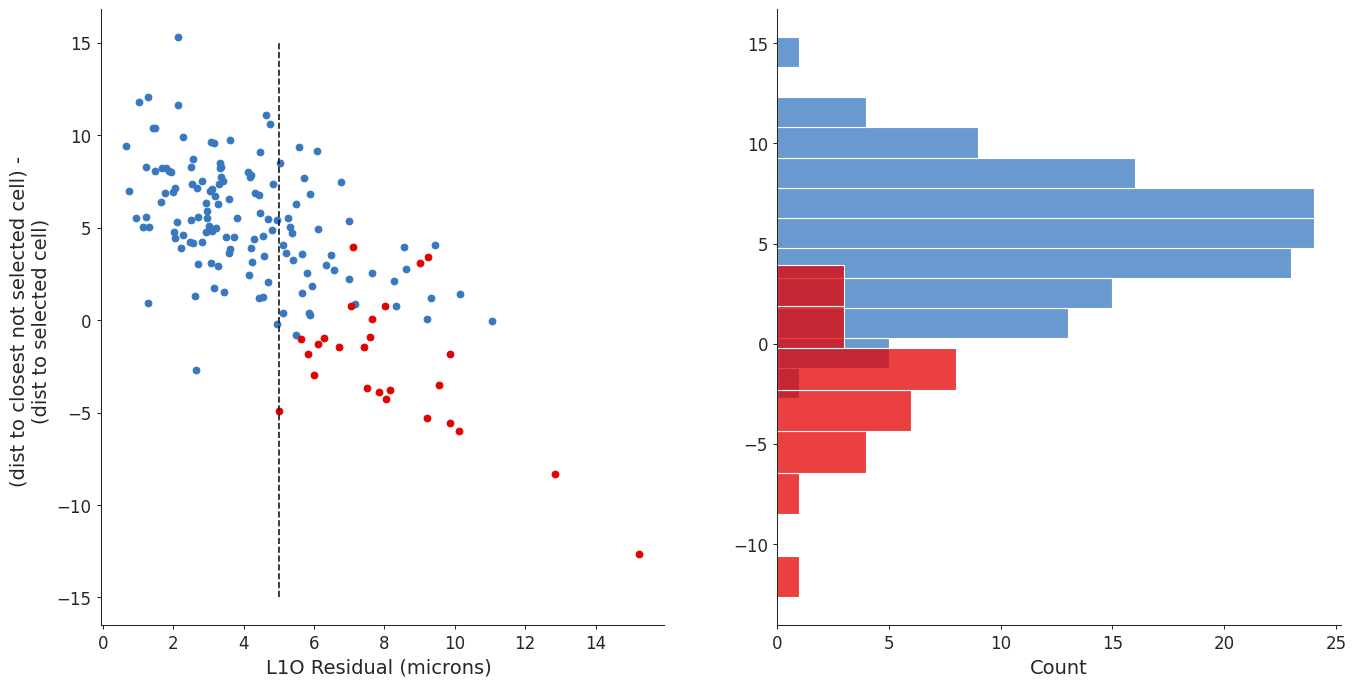

In [61]:
residuals = np.linalg.norm(np.stack(metrics_df2['em_final_em_nm'] - metrics_df2['test_centers_em_nm']),axis=1)
residual_cutoff = 5
mask = metrics_df2['em_id'].values != metrics_df2['predicted_nucleus_id'].values


fig, axes = plt.subplots(1,2,figsize=(16,8))

ax = axes[0]
ax.scatter(residuals[~mask]/1000,metrics_df['metric'].values[~mask]/1000,color=cc[2])
ax.scatter(residuals[mask]/1000,metrics_df['metric'].values[mask]/1000,color=cc[1])
ax.set_xlabel('L1O Residual (microns) ')
ax.set_ylabel('(dist to closest not selected cell) - \n(dist to selected cell) ')
ax.vlines(residual_cutoff,-15,15,ls='--',color='k')
ax = axes[1]
sns.histplot(y=metrics_df['metric'].values[~mask]/1000,color=cc[2],ax=ax)
sns.histplot(y=metrics_df['metric'].values[mask]/1000,color=cc[1],ax=ax)
plt.savefig(os.path.join(PlotDir,'correspondence_metric_usingjustcells.pdf'))

## correspondence to EM

In [27]:
coreg_2p_xyz = np.array(coreg_cells_df[["ophys_x", "ophys_y", "ophys_z"]],dtype=float)


In [28]:
coreg_em_nm = np.array(coreg_cells_df[["pt_position_x", "pt_position_y", "pt_position_z"]],dtype=float)

func_coreg_pts = np.array(coreg_cells_df[["optx", "opty", "optz"]],dtype=float)
em_coreg_pts = np.array(coreg_cells_df[["emx", "emy", "emz"]],dtype=float)

In [29]:
# Transform raw 2p coordinates into co-registration space (micron space)
coreg_2p_microns = transform_pts(func_raw2coreg_tform, coreg_2p_xyz)

# Transform em pt position into co-registration space
coreg_em_microns = transform_pts(em_final2coreg_tform, coreg_em_nm / em_final_voxel_size)



In [30]:
## Q: Are all of these transformations being fit and applied successively? I think so
transform_list = [
    {
        "name": "PolynomialModel",
        "order": 1,
        "regularization": [0, 0, 0, 0]
    },
    {
        "name": "ChunkedModel",
        "order": 1,
        "nchunks": 3,
        "axis": 0
    },
    {
        "name": "SplineModel",
        "ncntrl": [3, 3, 3],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [5, 5, 5],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e8]
    },
    {
        "name": "SplineModel",
        "ncntrl": [10, 10, 10],
         "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6] # originally last was 1e8
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e9]
    },
    {
        "name": "SplineModel",
        "ncntrl": [12, 12, 12],
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]  # originally last was 1e9
    },
    {
        "name": "SplineModel",
        "voronoi_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e6]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 1e5]
    },
    {
        "name": "SplineModel",
        "src_is_cntrl": True,
        "regularization": [1e-6, 1e-6, 1e-6, 1e-6, 5e4]
    },
        
]

transform_obj = {
        "name": "TransformList",
        "transforms": transform_list
    }

func_coreg_pts = np.array(coreg_df[["optx", "opty", "optz"]],dtype=float)
em_coreg_pts = np.array(coreg_df[["emx", "emy", "emz"]],dtype=float)
point_types = list(coreg_df['type'].values)
nPts = len(func_coreg_pts)
cell_indices = np.where(np.array(point_types) == 'Cell')[0]
nCells = len(cell_indices)
func_coreg_cells = func_coreg_pts[cell_indices]
em_coreg_cells = em_coreg_pts[cell_indices]

# estimate transformation
tform = coregister.transform.Transform(json=transform_obj)
tform.estimate(func_coreg_pts[cell_indices], em_coreg_pts[cell_indices])


In [31]:
#Get 2p functional data for column 1 volumn 3
nwb_file = '/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data/nwbs/processed/M409828_13_20181213.nwb'
with ROI_mask_nwb(nwb_file, vol=3, mode="r") as rmn:
    # import pdb; pdb.set_trace()
    all_roi_info = [*rmn.yield_roi_info()] 

In [32]:
add_these_invalid_cells = ['M409828_13_3_437','M409828_13_3_646']
# Get 2p ROI center of mass 
all_roi_raw_center_pts = np.array([center_from_pix_mask(roi.pix_mask).tolist() + [roi.plane_z] for roi in all_roi_info])
valid_cells = pika_scores > 0.5

# Get names
all_roi_names = np.array([roi.name for roi in all_roi_info])
all_roi_chasenames = np.array([roi.chase_ROI for roi in all_roi_info])
indy = np.where([name in add_these_invalid_cells for name in all_roi_chasenames])[0]
valid_cells[indy] = True

#Get pixel areas
all_roi_areas = np.array([len(roi.pix_mask[0]) for roi in all_roi_info])

# Transform raw 2p coordinates into co-registration space (micron space)
all_roi_func_coreg_pts = transform_pts(func_raw2coreg_tform, all_roi_raw_center_pts)

# #Subselect
# indices = get_array_subset_indices(all_roi_chasenames, valid_roi_ids)
all_roi_raw_center_pts = all_roi_raw_center_pts[valid_cells]
all_roi_func_coreg_pts = all_roi_func_coreg_pts[valid_cells]
all_roi_names = all_roi_names[valid_cells]
all_roi_chasenames = all_roi_chasenames[valid_cells]
# all_roi_em_final_pts_nms = all_roi_em_final_pts_nms[valid_cells]

#Transform 2p functional locations to EM using transform created using all co-registered cells
all_roi_em_coreg_pts = tform.tform(all_roi_func_coreg_pts)

# Transform coregistered points back into EM space 
all_roi_em_final_pts_voxels = transform_pts(em_coreg2final_tform, all_roi_em_coreg_pts)
all_roi_em_final_pts_nms = all_roi_em_final_pts_voxels * em_final_voxel_size
all_roi_em_final_pts_nms.shape

(2710, 3)

In [33]:
col_list = []
vol_list = []
pln_list = []
roi_list = []
for name in all_roi_chasenames:
    sub = name.split('_')
    col_list.append(int(sub[1][0]))
    vol_list.append(int(sub[1][1]))
    pln_list.append(int(sub[2]))
    roi_list.append(int(sub[3]))


In [34]:
correspondence_predictions_df = pd.DataFrame(index = all_roi_chasenames)
correspondence_predictions_df['mouse'] = '409828'
correspondence_predictions_df['column'] = col_list
correspondence_predictions_df['volume'] = vol_list
correspondence_predictions_df['plane'] = pln_list
correspondence_predictions_df['roi'] = roi_list

correspondence_predictions_df['ophys_raw'] = all_roi_raw_center_pts.tolist()
correspondence_predictions_df['ophys_xyz'] = all_roi_func_coreg_pts.tolist()
correspondence_predictions_df['em_xyz'] = all_roi_em_coreg_pts.tolist()
correspondence_predictions_df['em_transformed_nm'] = all_roi_em_final_pts_nms.tolist()
correspondence_predictions_df


,mouse,column,volume,plane,roi,ophys_raw,ophys_xyz,em_xyz,em_transformed_nm
M409828_13_1_0,409828,1,3,1,0,"[359.3029534310829, 46.654258196711886, 0.0]","[343.09136814437363, 271.41003317786124, 267.0]","[814.781017130655, 591.0005408535374, 86.39207...","[904176.0945875901, 635387.651967056, 86392.07..."
M409828_13_1_1,409828,1,3,1,1,"[188.0756666785559, 165.66188550117357, 0.0]","[204.6369840762803, 367.6396006162489, 267.0]","[694.9002431284628, 554.7545263744502, 170.587...","[784295.3386154663, 599141.6429393694, 170587...."
M409828_13_1_2,409828,1,3,1,2,"[316.042471238934, 343.19308775061126, 0.0]","[308.110942243802, 511.19133075514424, 267.0]","[806.3798653151345, 519.4460810990906, 316.344...","[895774.9440356027, 563833.2029744, 316344.031..."
M409828_13_1_3,409828,1,3,1,3,"[266.65854012937456, 207.0051239708172, 0.0]","[268.1790955486123, 401.0697432428028, 267.0]","[757.3310739220896, 553.1242780665114, 208.915...","[846726.160019496, 597511.3948766199, 208915.4..."
M409828_13_1_4,409828,1,3,1,4,"[356.6827367443309, 32.68995439974347, 0.0]","[340.97266093146595, 260.11849712763257, 267.0]","[812.0500452317469, 593.9856912484433, 75.6099...","[901445.1230994201, 638372.8019129954, 75609.9..."
...,...,...,...,...,...,...,...,...,...
M409828_13_6_706,409828,1,3,6,706,"[44.220969001781896, 179.24103602477138, 5.0]","[88.31607553484083, 378.61970172963015, 347.0]","[592.747947627443, 622.003180004973, 175.55090...","[682143.0584781516, 666390.2864556947, 175550...."
M409828_13_6_722,409828,1,3,6,722,"[136.17610263025156, 74.94656447800995, 5.0]","[162.6709965868214, 294.28719203691884, 347.0]","[649.7570613339403, 647.3745775608779, 102.268...","[739152.1636104783, 691761.6801957414, 102268...."
M409828_13_6_723,409828,1,3,6,723,"[271.2008489068389, 294.9268036312227, 5.0]","[271.8520064260699, 472.16321341620664, 347.0]","[767.7919383318175, 600.2689118859828, 274.828...","[857187.02285591, 644656.0216055384, 274828.76..."
M409828_13_6_776,409828,1,3,6,776,"[267.00777810667796, 352.8271413177855, 5.0]","[268.4614893770598, 518.9814264695614, 347.0]","[768.3100299760183, 585.9760666326014, 316.932...","[857705.1144221898, 630363.178501801, 316932.0..."


In [35]:
# define bounding box for table query
min_nm = all_roi_em_final_pts_nms.min(axis=0)
max_nm = all_roi_em_final_pts_nms.max(axis=0)

# 40 um buffer around area
buffer_um = 30
k = 1000
buffer_nm = buffer_um * k
buffer = np.array((buffer_nm, buffer_nm, buffer_nm))

query_bbox = np.array([
    min_nm - buffer,
    max_nm + buffer
])

#Get all cells in EM volume within bounding region
res = em_client.materialize.query_table(
    "nucleus_detection_v0",filter_spatial_dict={"pt_position": query_bbox})

#Extract point position 
nucleus_pts = np.array([i for i in res.pt_position])
nucleus_ids = np.array([i for i in res.id])
nucleus_pt_root_ids = np.array([i for i in res.pt_root_id])
nucleus_vols = np.array([i for i in res.volume])
print(nucleus_pts.shape)

# match using simple euclidean distance
kdt = scipy.spatial.KDTree(nucleus_pts)


(16568, 3)


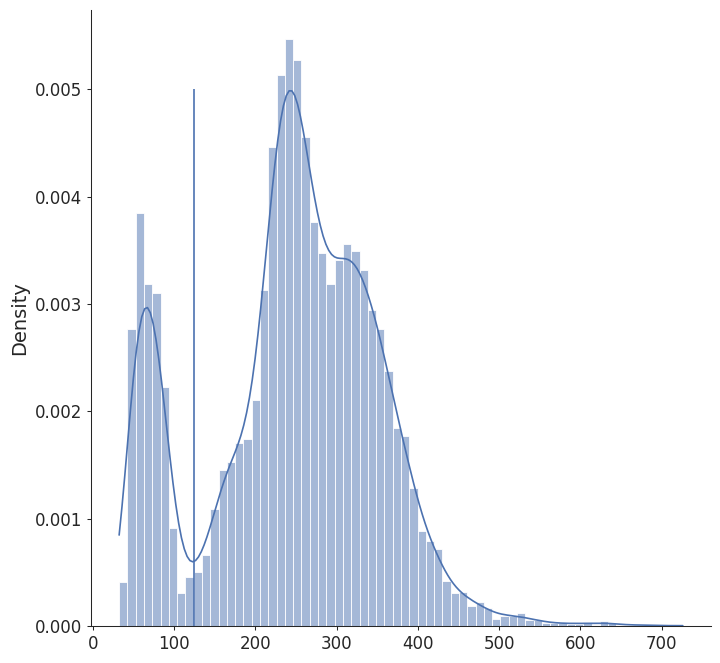

In [36]:
volume_thresh = 125

fig, ax = plt.subplots(figsize=(8,8))

sns.histplot(nucleus_vols,ax=ax,kde=True,alpha=0.5,stat='density')
ax.vlines(volume_thresh,0,0.005)

In [37]:
## Save point sets in coregistration space

# # Transform raw 2p coordinates into co-registration space (micron space)
# coreg_2p_microns = transform_pts(func_raw2coreg_tform, coreg_2p_xyz)

nucleus_points_standardtransform = em_client.transform_position_to_microns(nucleus_pts)

# Transform em pt position into co-registration space
tmp = nucleus_pts / em_final_voxel_size
nucleus_pts_microns = transform_pts(em_final2coreg_tform, tmp)
nucleus_pts_microns.shape


(16568, 3)

In [38]:
em_final_voxel_size

array([ 4.85,  4.85, 45.  ])

In [39]:
coreg_pts_2p = np.array(coreg_cells_df[["optx", "opty", "optz"]],dtype=float)
coreg_pts_em = np.array(coreg_cells_df[["emx", "emy", "emz"]],dtype=float)
coreg_2p_ids = np.array(coreg_cells_df['chase_key'],dtype='<U17')
coreg_em_ids = np.array(coreg_cells_df['em_id'],dtype=int)

idx_2p = np.zeros((len(coreg_2p_ids)),dtype=int)
idx_em = np.zeros((len(coreg_2p_ids)),dtype=int)
for ii, (id_2p, id_em) in enumerate(zip(coreg_2p_ids,coreg_em_ids)):
    idx_em[ii] = np.where(nucleus_ids == id_em)[0]
    idx_2p[ii] = np.where(all_roi_chasenames == id_2p)[0]

<Axes: ylabel='Count'>

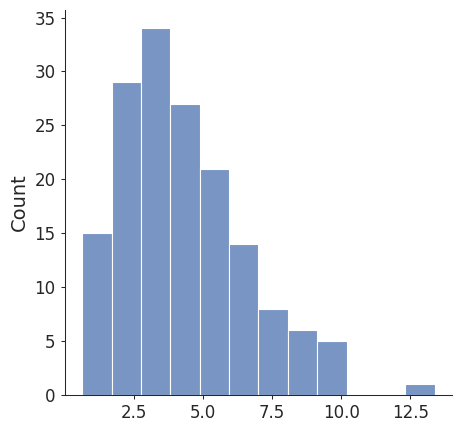

In [41]:

set1 = all_roi_em_final_pts_nms[idx_2p]

set2 = nucleus_pts[idx_em]

residuals = np.linalg.norm(set1-set2,axis=1)/1000
sns.histplot(residuals)

In [46]:
scalar = 1000

In [42]:
np.savez('/home/david.wyrick/projects/V1DD/coregistration/point_clouds_20230622.npz', nucleus_ids=nucleus_ids, nucleus_vols=nucleus_vols,
         nucleus_pts=nucleus_pts,nucleus_pts_microns=nucleus_pts_microns,nucleus_points_standardtransform=nucleus_points_standardtransform,
         all_roi_func_coreg_pts=all_roi_func_coreg_pts,all_roi_raw_center_pts=all_roi_raw_center_pts,all_roi_em_final_pts_nms=all_roi_em_final_pts_nms,all_roi_chasenames=all_roi_chasenames,
         coreg_pts_2p=coreg_pts_2p, coreg_pts_em=coreg_pts_em,coreg_2p_ids=coreg_2p_ids,coreg_em_ids=coreg_em_ids,
         idx_2p=idx_2p,idx_em=idx_em)

In [47]:
nNeurons = all_roi_em_final_pts_nms.shape[0]

# match using 2d refinement
refinement_cutoff_nm = 5*scalar
refinement_cutoff_metric_max = 5*scalar   
refinement_cutoff_metric_min = 3*scalar   
refinement_cutoff_metric = refinement_cutoff_metric_max
k=2
axes_2d = [0, 2]

#Define KD-tree based on em data
kdt = scipy.spatial.KDTree(nucleus_pts)

#Query the first and second nearest EM neighbours of the 2p data
distances, indices = kdt.query(all_roi_em_final_pts_nms, k=k)
metric = distances[:, 1] - distances[:, 0]

#Identify transformed 2p locations that are greater than 6microns to the nearest EM centroid AND has 2nd EM centroid that is >=8mm away 
refine_mask = ((distances[:, 0] >= refinement_cutoff_nm) & (metric <= refinement_cutoff_metric_max)) # | ((distances[:, 0] >= refinement_cutoff_nm) & (metric >= refinement_cutoff_metric_min))
# refine_mask2 = metric <= refinement_cutoff_metric_min
# refine_mask[refine_mask2] = True
# refine_mask3 = distances[:, 0] >= 7*scalar   
# refine_mask[refine_mask3] = True
print(f'{np.sum(refine_mask)}/{nNeurons} neurons are greater than {refinement_cutoff_nm/1000} microns from the closest EM centroid or have a distance metric less {refinement_cutoff_metric/1000} microns')

1474/2710 neurons are greater than 5.0 microns from the closest EM centroid or have a distance metric less 5.0 microns


Text(0.5, 0, '(dist to closest not selected cell) - \n(dist to selected cell) ')

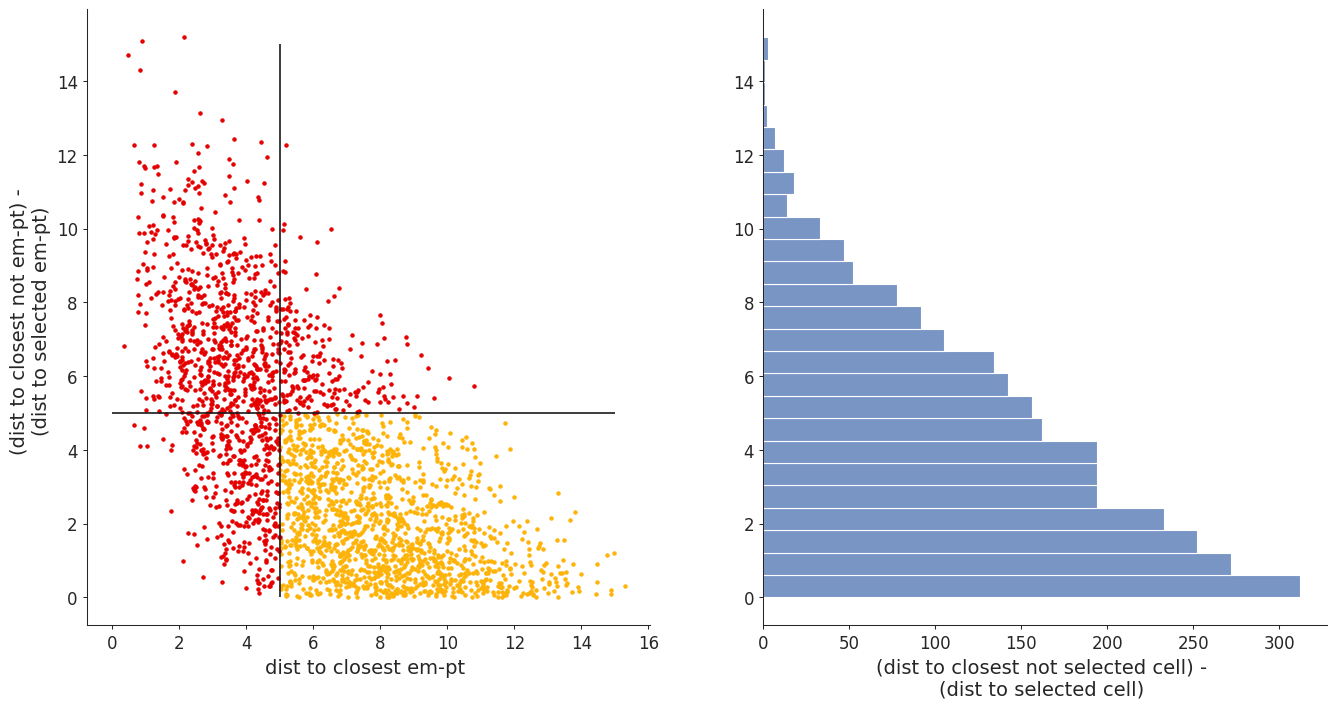

In [48]:
scalar = 1000
fig, axes = plt.subplots(1,2,figsize=(16,8))



ax = axes[0]
ax.scatter(distances[refine_mask, 0]/scalar,metric[refine_mask]/scalar,marker='.',color=cc[0])
ax.scatter(distances[~refine_mask, 0]/scalar,metric[~refine_mask]/scalar,marker='.',color=cc[1])
# ax.scatter(distances[refine_mask3, 0]/scalar,metric[refine_mask3]/scalar,marker='.',color=cc[2])
ax.set_ylabel('(dist to closest not em-pt) - \n(dist to selected em-pt) ')
ax.set_xlabel('dist to closest em-pt ')
ax.hlines(5,0,15,ls='-',color='k')
ax.vlines(5,0,15,ls='-',color='k')

ax = axes[1]
sns.histplot(y=metric/scalar,ax=ax)
ax.set_xlabel('(dist to closest not selected cell) - \n(dist to selected cell) ')

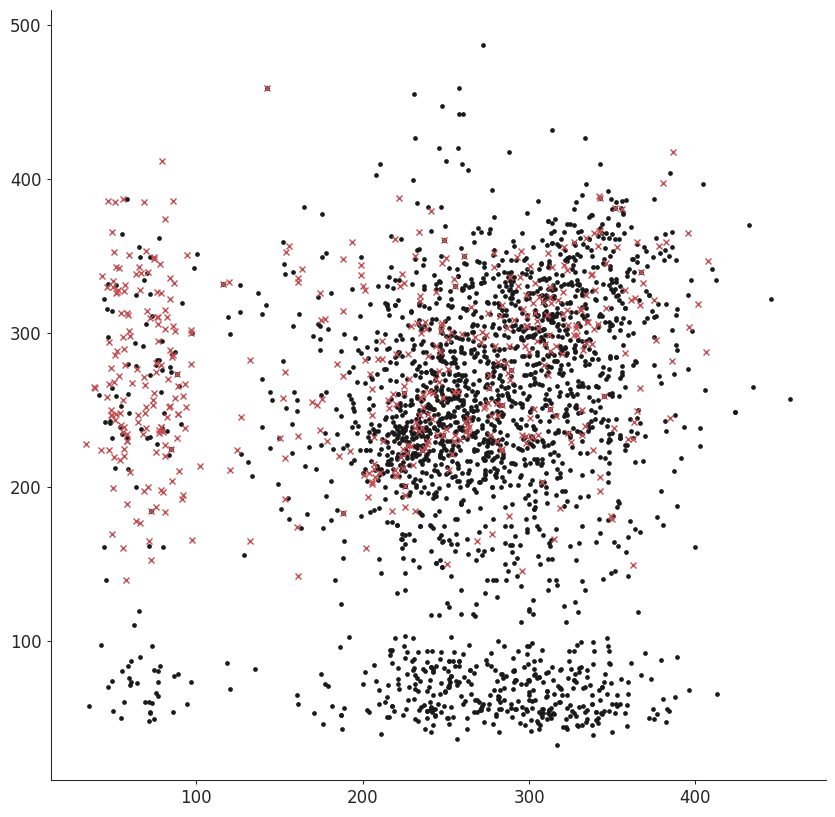

In [51]:
nv_sub = nucleus_vols[indices]

fig = plt.figure(figsize=(10,10))
plt.plot(nv_sub[~swap_mask,0],nv_sub[~swap_mask,1],'.k')
plt.plot(nv_sub[swap_mask,0],nv_sub[swap_mask,1],'rx')

In [50]:
#Get nucleus centroids from EM data 
predicted_nucleus_pts_centroids = nucleus_pts[indices[:, 0]]
predicted_nucleus_ids = nucleus_ids[indices[:, 0]]

swap_mask = np.zeros((nNeurons),dtype=bool)
vol_mask = np.zeros((nNeurons),dtype=bool)
choice_2D = []
distances_2D = []
#Loop over each cell and create unique KD tree based on 2 closest neurons
for idx in np.argwhere(refine_mask):
    #Create tree based only on x and z dimensions in EM 
    kdt_2d = scipy.spatial.KDTree(nucleus_pts[indices[idx]][0, :, axes_2d].T)
    
    #Get 2D xz distances
    dists_2d, idxs_2d = kdt_2d.query([all_roi_em_final_pts_nms[idx, axes_2d]],k=2)
    idxs_2d = np.squeeze(idxs_2d)

    #Choose closest neuron based on xz distance
    nucleus_idx = indices[idx][0][idxs_2d[0]]

    #But make sure it is greater than the volume threshold
    nv_sub = np.squeeze(nucleus_vols[indices[idx]])
    
    if (idxs_2d[0] ==  1) & (nv_sub[idxs_2d[0]] > volume_thresh):
        swap_mask[idx] = True
    
    if (nv_sub[idxs_2d[0]] < volume_thresh) & (nv_sub[idxs_2d[1]] > volume_thresh):
        
        nucleus_idx = indices[idx][0][idxs_2d[1]]
        if idxs_2d[1] ==  1:
            swap_mask[idx] = True
    
    if (idxs_2d[0] ==  1) & (nv_sub[idxs_2d[0]] < volume_thresh):
        vol_mask[idx] = True

    # if np.abs(distances[idx][0][idxs_2d[0]] - distances[idx][0][0]) > 5*scalar:
    #     distances_2D.append((distances[idx][0][0], 0,distances[idx][0][0]))
    #     choice_2D.append(idxs_2d[0])
    
    # else:
    distances_2D.append((distances[idx][0][0], dists_2d[0],distances[idx][0][idxs_2d[0]]))
    choice_2D.append(idxs_2d[0])

    #Update
    predicted_nucleus_pts_centroids[idx] = nucleus_pts[nucleus_idx]
    predicted_nucleus_ids[idx] = nucleus_ids[nucleus_idx]
print(f'{np.sum(swap_mask)}/{np.sum(refine_mask)} of these, we chose the 2nd closest cell')
print(f'{np.sum(vol_mask)}/{np.sum(refine_mask)} of these, we would have chosen the 2nd closest cell, but the volume was less than {volume_thresh}')

468/1474 of these, we chose the 2nd closest cell
44/1474 of these, we would have chosen the 2nd closest cell, but the volume was less than 125


In [52]:
tmp = np.array(distances_2D)
fig, axes = plt.subplots(1,3,figsize=(24,8))
for i in range(5):

    indy = np.where(np.array(choice_2D) == i)[0]
    axes[0].scatter(tmp[indy,0]/scalar,tmp[indy,2]/scalar,color=cc[i])
    axes[0].plot([0,20],[0,20],'-k')
    axes[1].scatter(tmp[indy,0]/scalar,tmp[indy,1]/scalar,color=cc[i])
    axes[1].plot([0,20],[0,20],'-k')

    axes[2].scatter(tmp[indy,1]/scalar,tmp[indy,2]/scalar,color=cc[i])
    axes[2].plot([0,20],[0,20],'-k')
axes[0].vlines(5,0,20)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1474, 3) + inhomogeneous part.

(array([0, 1, 2]), array([1006,  442,  224]))

In [53]:
correspondence_predictions_df['predicted_em_id'] = predicted_nucleus_ids
correspondence_predictions_df['predicted_pt_position'] = predicted_nucleus_pts_centroids.tolist()
correspondence_predictions_df.to_csv('/home/david.wyrick/Git/allen_v1dd/data_frames/correspondence_predictions_20230622.csv')
correspondence_predictions_df

,mouse,column,volume,plane,roi,ophys_raw,ophys_xyz,em_xyz,em_transformed_nm,predicted_em_id,predicted_pt_position
M409828_13_1_0,409828,1,3,1,0,"[359.3029534310829, 46.654258196711886, 0.0]","[343.09136814437363, 271.41003317786124, 267.0]","[814.781017130655, 591.0005408535374, 86.39207...","[904176.0945875901, 635387.651967056, 86392.07...",364918,"[905126, 641519, 88020]"
M409828_13_1_1,409828,1,3,1,1,"[188.0756666785559, 165.66188550117357, 0.0]","[204.6369840762803, 367.6396006162489, 267.0]","[694.9002431284628, 554.7545263744502, 170.587...","[784295.3386154663, 599141.6429393694, 170587....",275935,"[787718, 591778, 169515]"
M409828_13_1_2,409828,1,3,1,2,"[316.042471238934, 343.19308775061126, 0.0]","[308.110942243802, 511.19133075514424, 267.0]","[806.3798653151345, 519.4460810990906, 316.344...","[895774.9440356027, 563833.2029744, 316344.031...",353313,"[902255, 558254, 308655]"
M409828_13_1_3,409828,1,3,1,3,"[266.65854012937456, 207.0051239708172, 0.0]","[268.1790955486123, 401.0697432428028, 267.0]","[757.3310739220896, 553.1242780665114, 208.915...","[846726.160019496, 597511.3948766199, 208915.4...",276632,"[846383, 592942, 209025]"
M409828_13_1_4,409828,1,3,1,4,"[356.6827367443309, 32.68995439974347, 0.0]","[340.97266093146595, 260.11849712763257, 267.0]","[812.0500452317469, 593.9856912484433, 75.6099...","[901445.1230994201, 638372.8019129954, 75609.9...",364702,"[901324, 636320, 75465]"
...,...,...,...,...,...,...,...,...,...,...,...
M409828_13_6_706,409828,1,3,6,706,"[44.220969001781896, 179.24103602477138, 5.0]","[88.31607553484083, 378.61970172963015, 347.0]","[592.747947627443, 622.003180004973, 175.55090...","[682143.0584781516, 666390.2864556947, 175550....",217224,"[685441, 672016, 177030]"
M409828_13_6_722,409828,1,3,6,722,"[136.17610263025156, 74.94656447800995, 5.0]","[162.6709965868214, 294.28719203691884, 347.0]","[649.7570613339403, 647.3745775608779, 102.268...","[739152.1636104783, 691761.6801957414, 102268....",290529,"[740692, 685906, 104670]"
M409828_13_6_723,409828,1,3,6,723,"[271.2008489068389, 294.9268036312227, 5.0]","[271.8520064260699, 472.16321341620664, 347.0]","[767.7919383318175, 600.2689118859828, 274.828...","[857187.02285591, 644656.0216055384, 274828.76...",294550,"[857635, 639502, 270495]"
M409828_13_6_776,409828,1,3,6,776,"[267.00777810667796, 352.8271413177855, 5.0]","[268.4614893770598, 518.9814264695614, 347.0]","[768.3100299760183, 585.9760666326014, 316.932...","[857705.1144221898, 630363.178501801, 316932.0...",295598,"[859420, 634380, 318690]"


Plane 1:  min: 216.2, max: 261.2,  mean: 237.9, median: 237.6 width: 45.0, 95th%tile: 254.5, std: 10.0
Plane 2:  min: 227.5, max: 280.4,  mean: 252.6, median: 252.8 width: 52.9, 95th%tile: 268.9, std: 10.0
Plane 3:  min: 241.6, max: 292.8,  mean: 266.6, median: 266.1 width: 51.2, 95th%tile: 283.4, std: 11.0
Plane 4:  min: 254.2, max: 306.5,  mean: 281.7, median: 281.3 width: 52.4, 95th%tile: 299.4, std: 11.1
Plane 5:  min: 266.6, max: 323.6,  mean: 295.9, median: 295.4 width: 56.9, 95th%tile: 315.3, std: 11.8
Plane 6:  min: 283.8, max: 338.4,  mean: 311.0, median: 309.9 width: 54.7, 95th%tile: 331.0, std: 11.5
[238, 253, 268, 283, 298, 313]


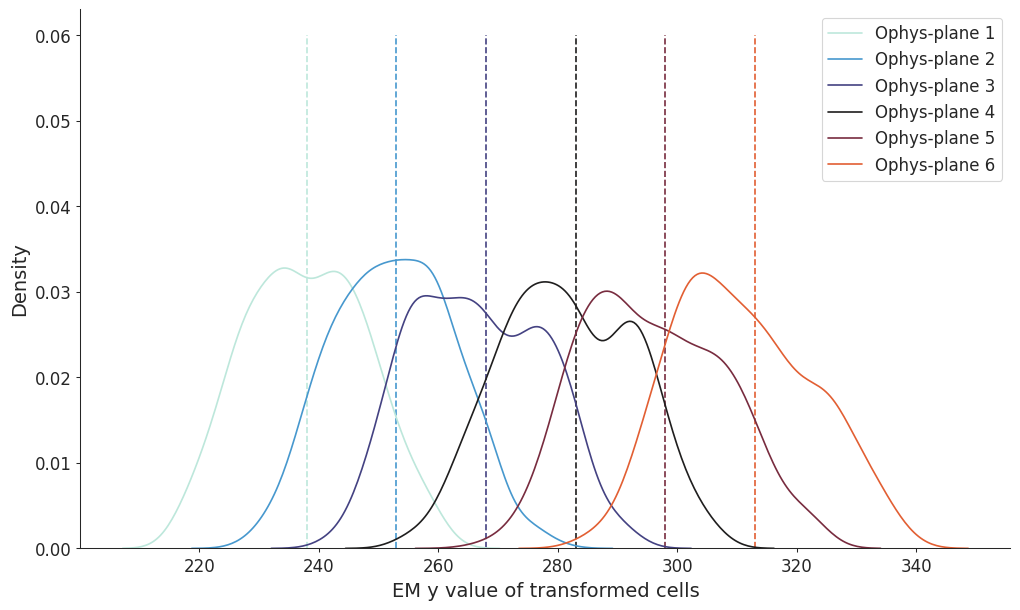

In [57]:
scalar = 1000

##Plot cells from each plane and the corresponding EM locations
fig, ax = plt.subplots(figsize=(12,7))
cc = sns.color_palette("icefire", as_cmap=True)
em_y_list = []
marker_list = ['o','x','^','*','+','s']
plane0 = 238

em_y_guesses = [plane0 + 15*i for i in range(6)]
for ii in range(6):
    

    # #Plot all 2p cells in plane
    # indy = all_2p_cell_centers[:,2] == ii
    # ax.scatter(all_2p_cell_centers[indy,0], all_2p_cell_centers[indy,1],marker= '.', color='k',s=35)

    sub_df = correspondence_predictions_df.loc[correspondence_predictions_df.plane == ii+1]
    em_xyz = np.stack(sub_df["predicted_pt_position"].values)
    em_coreg_microms = em_client.transform_position_to_microns(em_xyz)
    
    em_xz = em_coreg_microms[:,[0,2]] #np.array(sub_df[["pt_position_x", "pt_position_z"]],dtype=float)/scalar
    em_y = em_coreg_microms[:,1]
    
    ophys_xy = np.stack(sub_df["ophys_raw"].values)
    
    em_y_list.append(em_y)
    
    sns.kdeplot(em_y,color=cc(ii/6),ax=ax,label=f'Ophys-plane {ii+1}')
    ax.vlines(em_y_guesses[ii],0,0.06,color=cc(ii/6),ls='--',zorder=0)
    # ax.scatter(em_xz[:,0],em_y,color=cc(ii/6),marker=marker_list[ii],s=30,label=f'Ophys-plane {ii+1}')
    # ax.hlines(em_y_guesses[ii],650,1100,color=cc(ii/6),ls='--',zorder=0)
    
    # print(f'Ophys plane {ii+1}: [{np.min(em_y):.1f},{np.max(em_y):.1f}], [{np.mean(em_y)-50:.1f},{np.mean(em_y)+50:.1f}]')
    print(f'Plane {ii+1}:  min: {np.min(em_y):.1f}, max: {np.max(em_y):.1f},  mean: {np.mean(em_y):.1f}, median: {np.median(em_y):.1f} width: {np.max(em_y)-np.min(em_y):.1f}, 95th%tile: {np.percentile(em_y,95):.1f}, std: {np.std(em_y):.1f}')
    
    # mean_list.append(np.median(em_y))
    
ax.set_xlabel('EM y value of transformed cells')
ax.legend()
print(em_y_guesses)


237.85187205702394 400 409
252.55077949985537 458 470
266.55392565840924 471 485
281.6529023888645 456 478
295.9384263336002 410 438
310.9621818592226 411 430


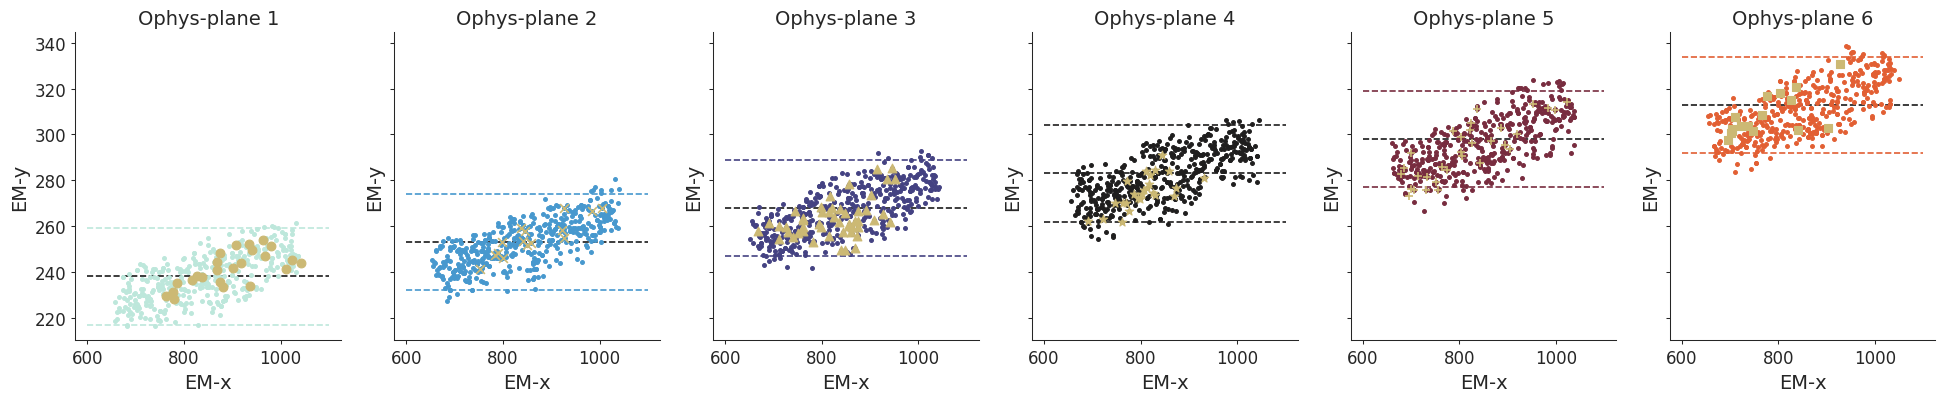

In [60]:
scalar = 1000
##Plot coregistered cells from each plane and the corresponding EM locations

fig, axes = plt.subplots(1,6,figsize=(24,4),sharey=True,sharex=True)
cc = sns.color_palette("icefire", as_cmap=True)
em_y_list = []
marker_list = ['o','x','^','*','+','s']
plane0 = 238
em_y_guesses = [plane0 + 15*i for i in range(6)]

# plane0 = 353
# em_y_guesses = [plane0 + 13*i for i in range(6)]

width = 21
for ii in range(6):
    
    # #Plot all 2p cells in plane
    # indy = all_2p_cell_centers[:,2] == ii
    # ax.scatter(all_2p_cell_centers[indy,0], all_2p_cell_centers[indy,1],marker= '.', color='k',s=35)

    sub_df = correspondence_predictions_df.loc[correspondence_predictions_df.plane == ii+1]
    em_xyz = np.stack(sub_df["predicted_pt_position"].values)
    em_coreg_microms = em_client.transform_position_to_microns(em_xyz)
    
    em_xz = em_coreg_microms[:,[0,2]] #np.array(sub_df[["pt_position_x", "pt_position_z"]],dtype=float)/scalar
    em_y = em_coreg_microms[:,1]
    
    
    # ophys_xy = np.array(sub_df[["ophys_x", "ophys_y"]],dtype=float)

    em_y_list.append(em_y)
    
    # sns.kdeplot(em_y,color=cc(ii/6),ax=ax,label=f'Ophys-plane {ii+1}')
    # ax.vlines(em_y_guesses[ii],0,0.022,color=cc(ii/6),ls='--',zorder=0)
    
    ax = axes[ii]; ax.set_title(f'Ophys-plane {ii+1}')
    ax.scatter(em_xz[:,0],em_y,color=cc(ii/6),marker='.',s=30)
    
    ax.hlines(em_y_guesses[ii],600,1100,color='k',ls='--',zorder=0)
    
    ax.hlines(em_y_guesses[ii]-width,600,1100,color=cc(ii/6),ls='--',zorder=0)
    # if iPlane == 5:
    #     ax.hlines(em_y_guesses[ii]+25,-200,200,color=cc(ii/6),ls='--',zorder=0)
    #     print((em_y > em_y_guesses[ii]-22) & (em_y < em_y_guesses[ii]+25))
    # else:
    ax.hlines(em_y_guesses[ii]+width,600,1100,color=cc(ii/6),ls='--',zorder=0)
    print(np.mean(em_y),np.sum((em_y > em_y_guesses[ii]-width) & (em_y < em_y_guesses[ii]+width)),len(em_y))
    # ax.hlines(lower_plane_bounds[ii],-200,200,color=cc(ii/6),ls='--',zorder=0)
    # ax.hlines(upper_plane_bounds[ii],-200,200,color=cc(ii/6),ls='--',zorder=0)
    ax.set_xlabel('EM-x')
    ax.set_ylabel('EM-y')
    # print(f'Ophys plane {ii+1}: [{np.min(em_y):.1f},{np.max(em_y):.1f}], [{np.mean(em_y)-50:.1f},{np.mean(em_y)+50:.1f}]')
    
    sub_df = coreg_df.loc[coreg_df.ophys_plane == ii+1]
    em_xyz = np.stack(sub_df["pt_position"].values)
    em_coreg_microms = em_client.transform_position_to_microns(em_xyz)
    
    em_xz = em_coreg_microms[:,[0,2]] #np.array(sub_df[["pt_position_x", "pt_position_z"]],dtype=float)/scalar
    em_y = em_coreg_microms[:,1]
    ax.scatter(em_xz[:,0],em_y,color='y',marker=marker_list[ii],s=40)
    
    # if ii == 2:
    #     sub_df.iloc[np.where(em_y > 400)[0]]
    #     pdb.set_trace()
    
# ax.set_xlabel('EM y value of coregistered cells')
# ax.legend()
    

In [3]:
correspondence_predictions_df = pd.read_csv('/home/david.wyrick/Git/allen_v1dd/data_frames/correspondence_predictions_20230612.csv')
correspondence_predictions_df

,Unnamed: 0,mouse,column,volume,plane,roi,ophys_raw,ophys_xyz,em_xyz,em_transformed_nm,predicted_em_id,predicted_pt_position
0,M409828_13_1_0,409828,1,3,1,0,"[359.3029534310829, 46.654258196711886, 0.0]","[343.09136814437363, 271.41003317786124, 267.0]","[814.781017130655, 591.0005408535374, 86.39207...","[904176.0945875901, 635387.651967056, 86392.07...",364918,"[905126, 641519, 88020]"
1,M409828_13_1_1,409828,1,3,1,1,"[188.0756666785559, 165.66188550117357, 0.0]","[204.6369840762803, 367.6396006162489, 267.0]","[694.9002431284628, 554.7545263744502, 170.587...","[784295.3386154663, 599141.6429393694, 170587....",275935,"[787718, 591778, 169515]"
2,M409828_13_1_2,409828,1,3,1,2,"[316.042471238934, 343.19308775061126, 0.0]","[308.110942243802, 511.19133075514424, 267.0]","[806.3798653151345, 519.4460810990906, 316.344...","[895774.9440356027, 563833.2029744, 316344.031...",353313,"[902255, 558254, 308655]"
3,M409828_13_1_3,409828,1,3,1,3,"[266.65854012937456, 207.0051239708172, 0.0]","[268.1790955486123, 401.0697432428028, 267.0]","[757.3310739220896, 553.1242780665114, 208.915...","[846726.160019496, 597511.3948766199, 208915.4...",276632,"[846383, 592942, 209025]"
4,M409828_13_1_4,409828,1,3,1,4,"[356.6827367443309, 32.68995439974347, 0.0]","[340.97266093146595, 260.11849712763257, 267.0]","[812.0500452317469, 593.9856912484433, 75.6099...","[901445.1230994201, 638372.8019129954, 75609.9...",364702,"[901324, 636320, 75465]"
...,...,...,...,...,...,...,...,...,...,...,...,...
2705,M409828_13_6_706,409828,1,3,6,706,"[44.220969001781896, 179.24103602477138, 5.0]","[88.31607553484083, 378.61970172963015, 347.0]","[592.747947627443, 622.003180004973, 175.55090...","[682143.0584781516, 666390.2864556947, 175550....",217224,"[685441, 672016, 177030]"
2706,M409828_13_6_722,409828,1,3,6,722,"[136.17610263025156, 74.94656447800995, 5.0]","[162.6709965868214, 294.28719203691884, 347.0]","[649.7570613339403, 647.3745775608779, 102.268...","[739152.1636104783, 691761.6801957414, 102268....",290529,"[740692, 685906, 104670]"
2707,M409828_13_6_723,409828,1,3,6,723,"[271.2008489068389, 294.9268036312227, 5.0]","[271.8520064260699, 472.16321341620664, 347.0]","[767.7919383318175, 600.2689118859828, 274.828...","[857187.02285591, 644656.0216055384, 274828.76...",294550,"[857635, 639502, 270495]"
2708,M409828_13_6_776,409828,1,3,6,776,"[267.00777810667796, 352.8271413177855, 5.0]","[268.4614893770598, 518.9814264695614, 347.0]","[768.3100299760183, 585.9760666326014, 316.932...","[857705.1144221898, 630363.178501801, 316932.0...",295598,"[859420, 634380, 318690]"


In [64]:
correspondence_predictions_df.to_hdf('/home/david.wyrick/Git/allen_v1dd/data_frames/correspondence_predictions_20230622.h5','table')

In [66]:
correspondence_predictions_df = pd.read_hdf('/home/david.wyrick/Git/allen_v1dd/data_frames/correspondence_predictions_20230622.h5','table')
test_df

,mouse,column,volume,plane,roi,ophys_raw,ophys_xyz,em_xyz,em_transformed_nm,predicted_em_id,predicted_pt_position
M409828_13_1_0,409828,1,3,1,0,"[359.3029534310829, 46.654258196711886, 0.0]","[343.09136814437363, 271.41003317786124, 267.0]","[814.781017130655, 591.0005408535374, 86.39207...","[904176.0945875901, 635387.651967056, 86392.07...",364918,"[905126, 641519, 88020]"
M409828_13_1_1,409828,1,3,1,1,"[188.0756666785559, 165.66188550117357, 0.0]","[204.6369840762803, 367.6396006162489, 267.0]","[694.9002431284628, 554.7545263744502, 170.587...","[784295.3386154663, 599141.6429393694, 170587....",275935,"[787718, 591778, 169515]"
M409828_13_1_2,409828,1,3,1,2,"[316.042471238934, 343.19308775061126, 0.0]","[308.110942243802, 511.19133075514424, 267.0]","[806.3798653151345, 519.4460810990906, 316.344...","[895774.9440356027, 563833.2029744, 316344.031...",353313,"[902255, 558254, 308655]"
M409828_13_1_3,409828,1,3,1,3,"[266.65854012937456, 207.0051239708172, 0.0]","[268.1790955486123, 401.0697432428028, 267.0]","[757.3310739220896, 553.1242780665114, 208.915...","[846726.160019496, 597511.3948766199, 208915.4...",276632,"[846383, 592942, 209025]"
M409828_13_1_4,409828,1,3,1,4,"[356.6827367443309, 32.68995439974347, 0.0]","[340.97266093146595, 260.11849712763257, 267.0]","[812.0500452317469, 593.9856912484433, 75.6099...","[901445.1230994201, 638372.8019129954, 75609.9...",364702,"[901324, 636320, 75465]"
...,...,...,...,...,...,...,...,...,...,...,...
M409828_13_6_706,409828,1,3,6,706,"[44.220969001781896, 179.24103602477138, 5.0]","[88.31607553484083, 378.61970172963015, 347.0]","[592.747947627443, 622.003180004973, 175.55090...","[682143.0584781516, 666390.2864556947, 175550....",217224,"[685441, 672016, 177030]"
M409828_13_6_722,409828,1,3,6,722,"[136.17610263025156, 74.94656447800995, 5.0]","[162.6709965868214, 294.28719203691884, 347.0]","[649.7570613339403, 647.3745775608779, 102.268...","[739152.1636104783, 691761.6801957414, 102268....",290529,"[740692, 685906, 104670]"
M409828_13_6_723,409828,1,3,6,723,"[271.2008489068389, 294.9268036312227, 5.0]","[271.8520064260699, 472.16321341620664, 347.0]","[767.7919383318175, 600.2689118859828, 274.828...","[857187.02285591, 644656.0216055384, 274828.76...",294550,"[857635, 639502, 270495]"
M409828_13_6_776,409828,1,3,6,776,"[267.00777810667796, 352.8271413177855, 5.0]","[268.4614893770598, 518.9814264695614, 347.0]","[768.3100299760183, 585.9760666326014, 316.932...","[857705.1144221898, 630363.178501801, 316932.0...",295598,"[859420, 634380, 318690]"
